# Plot das variáveis com período horário do Oceano Atlântico

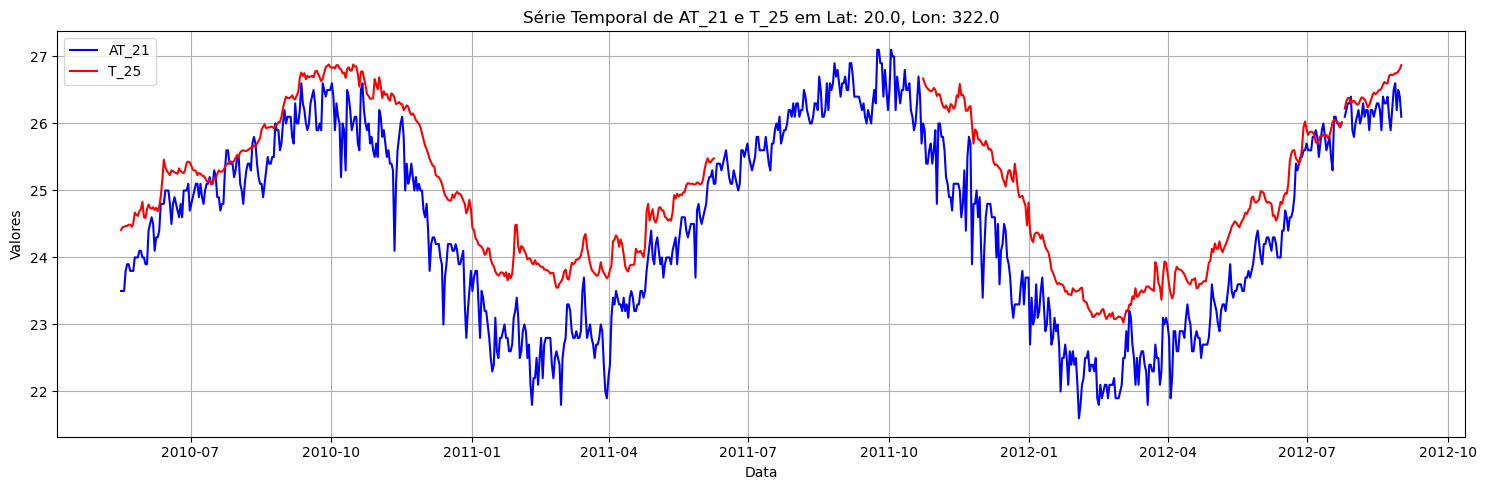

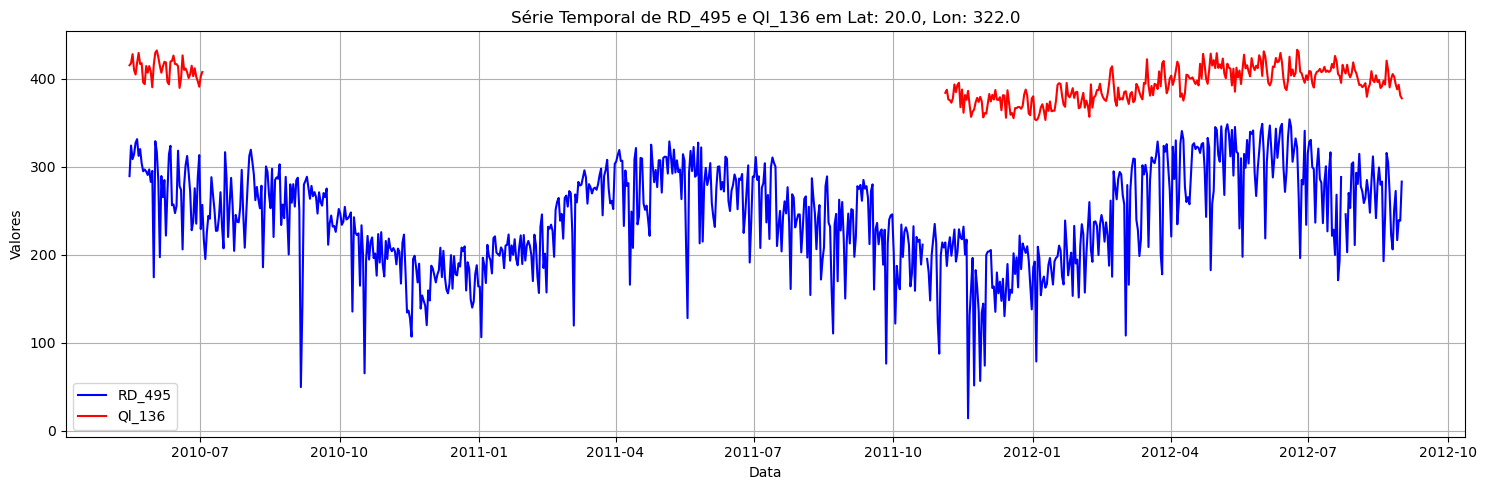

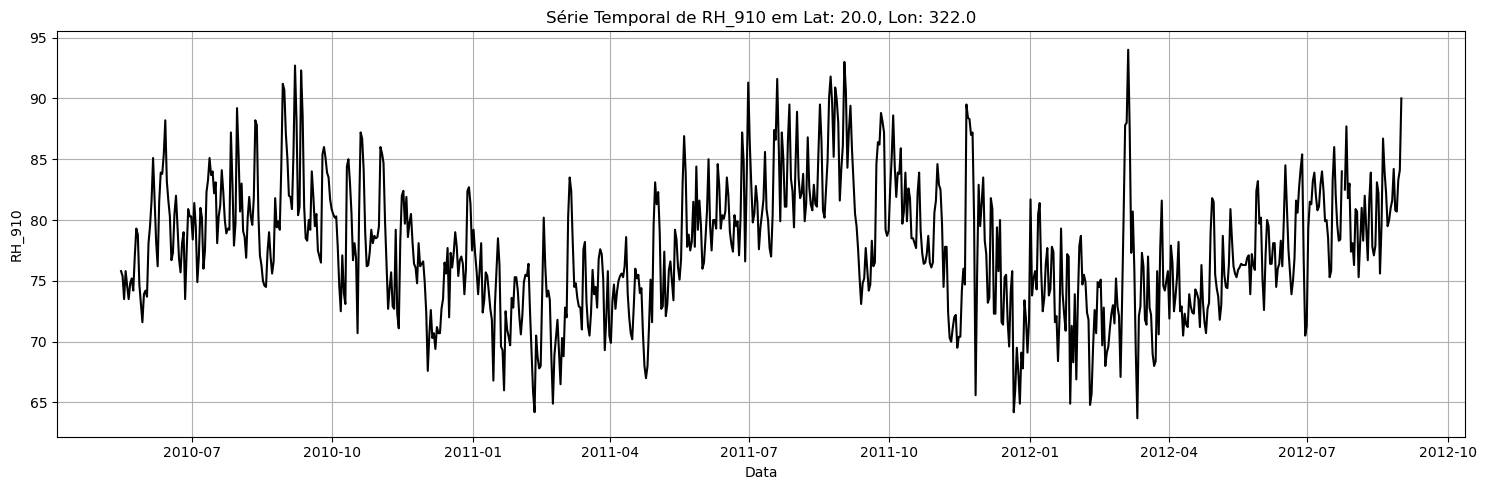

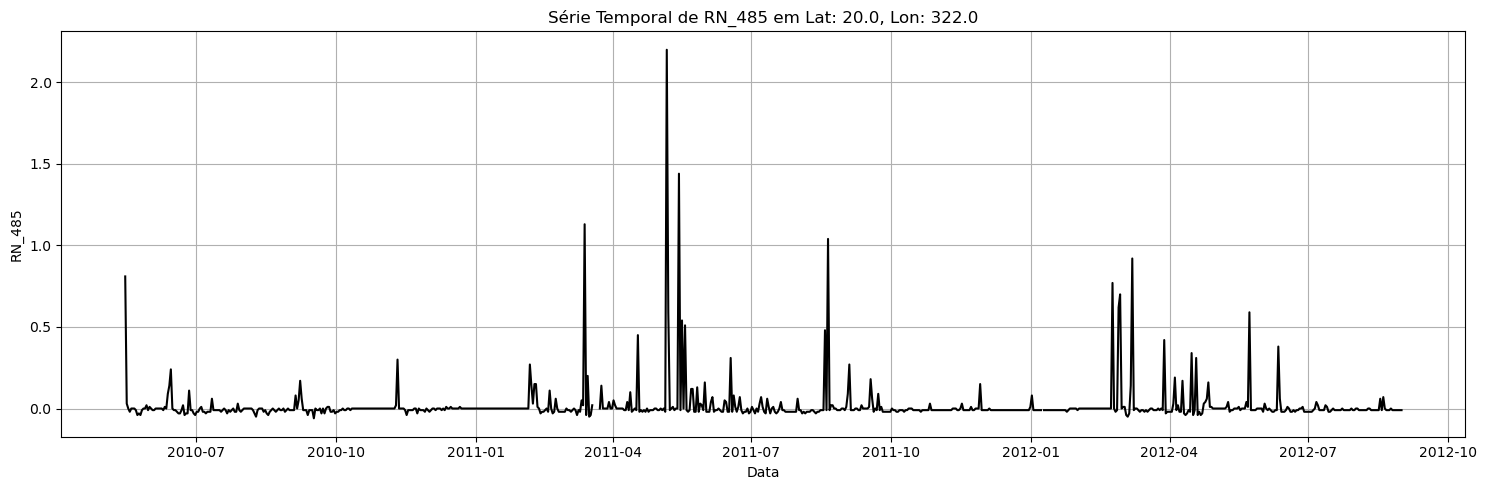

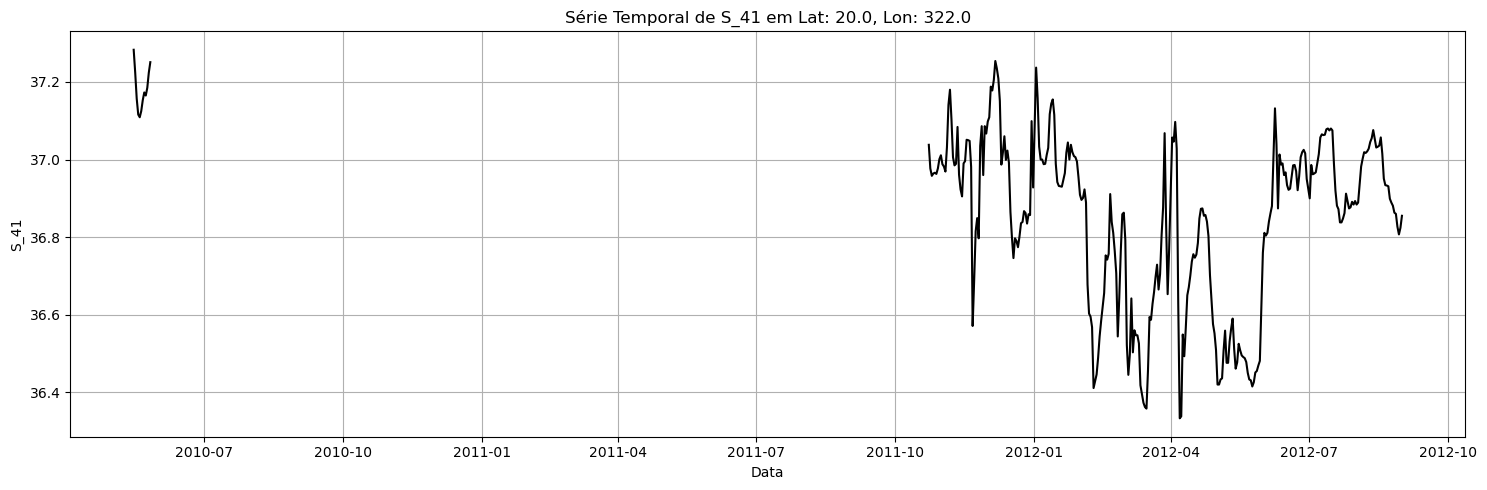

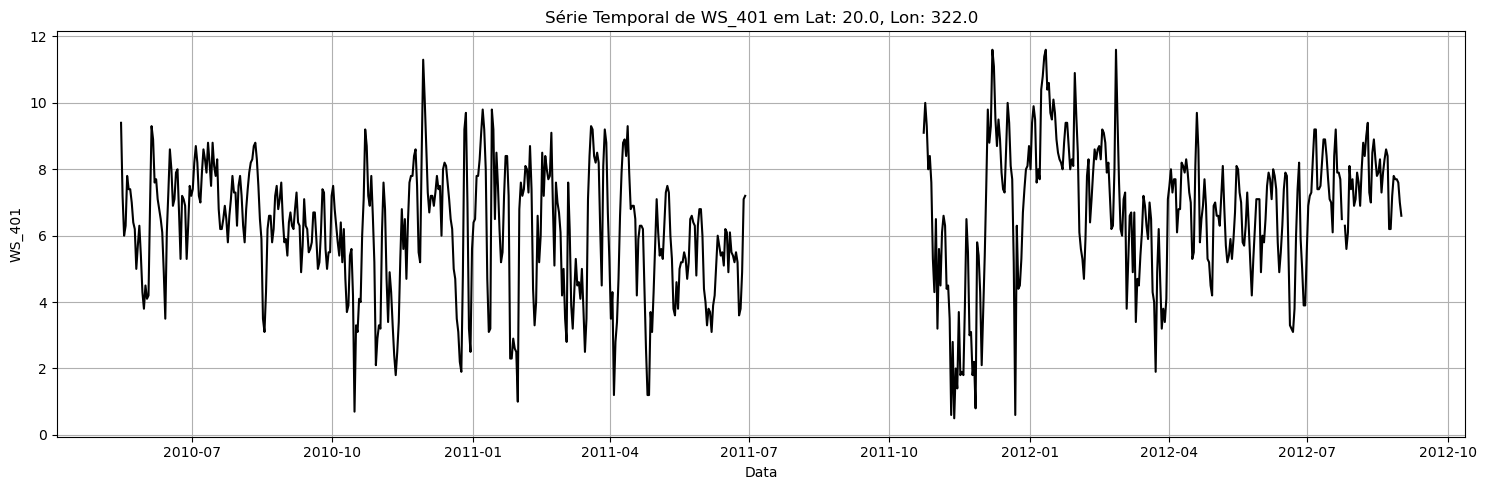

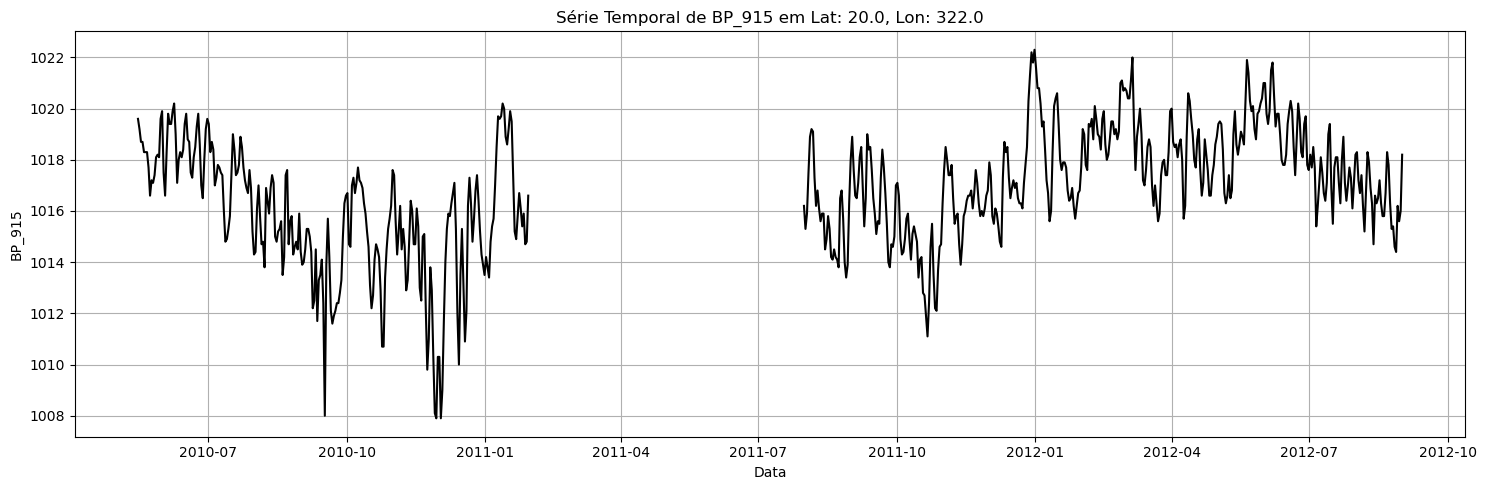

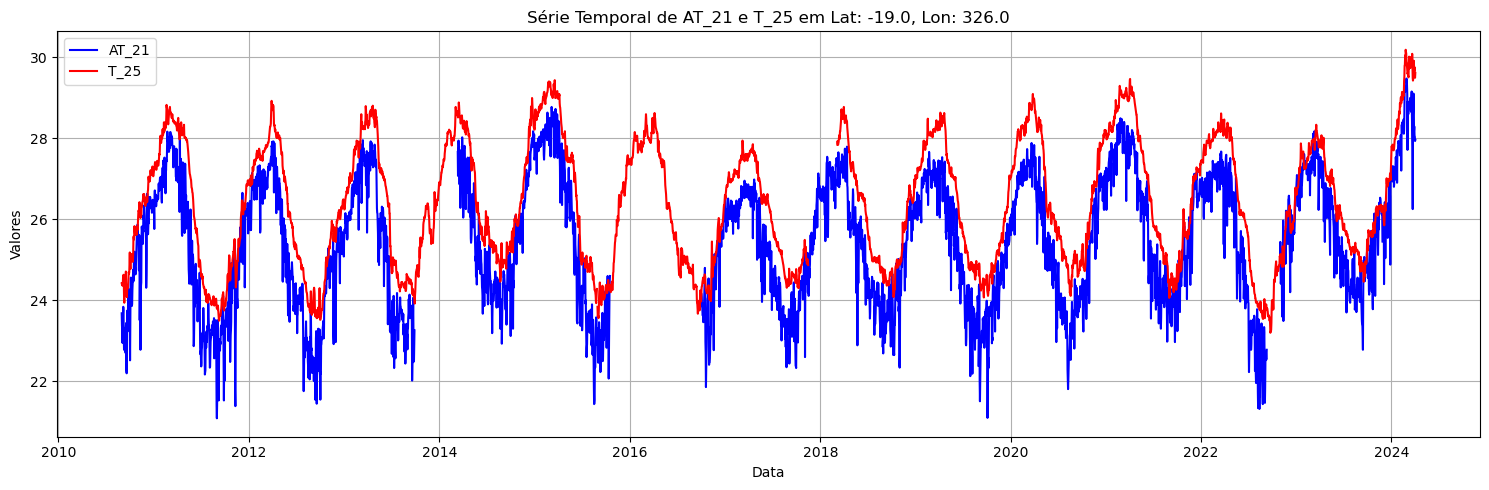

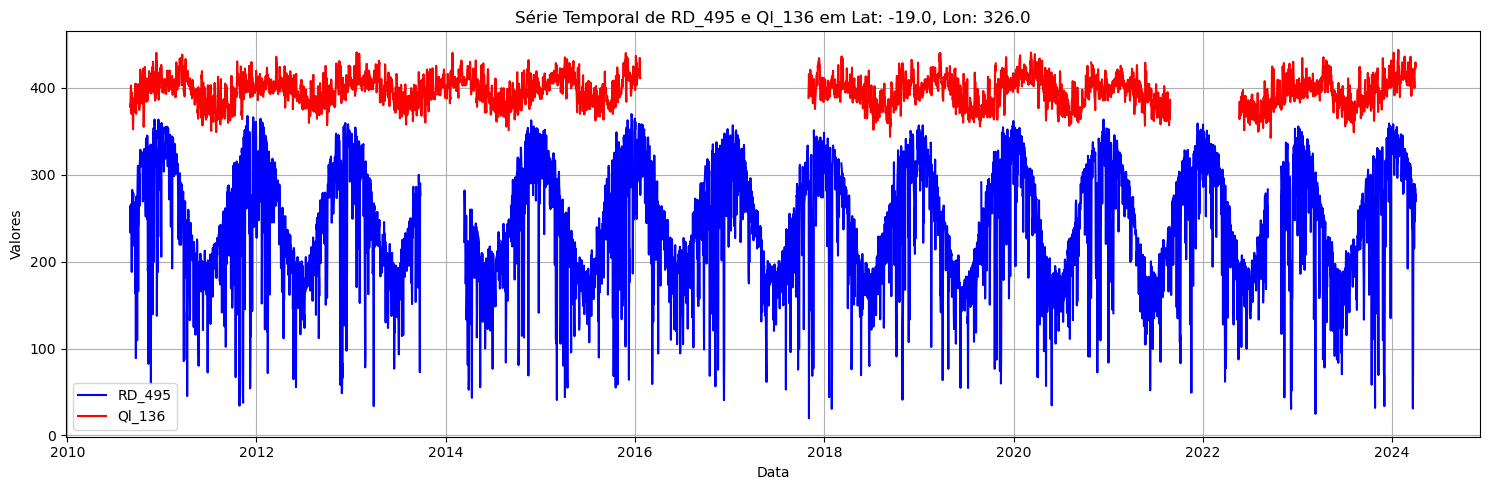

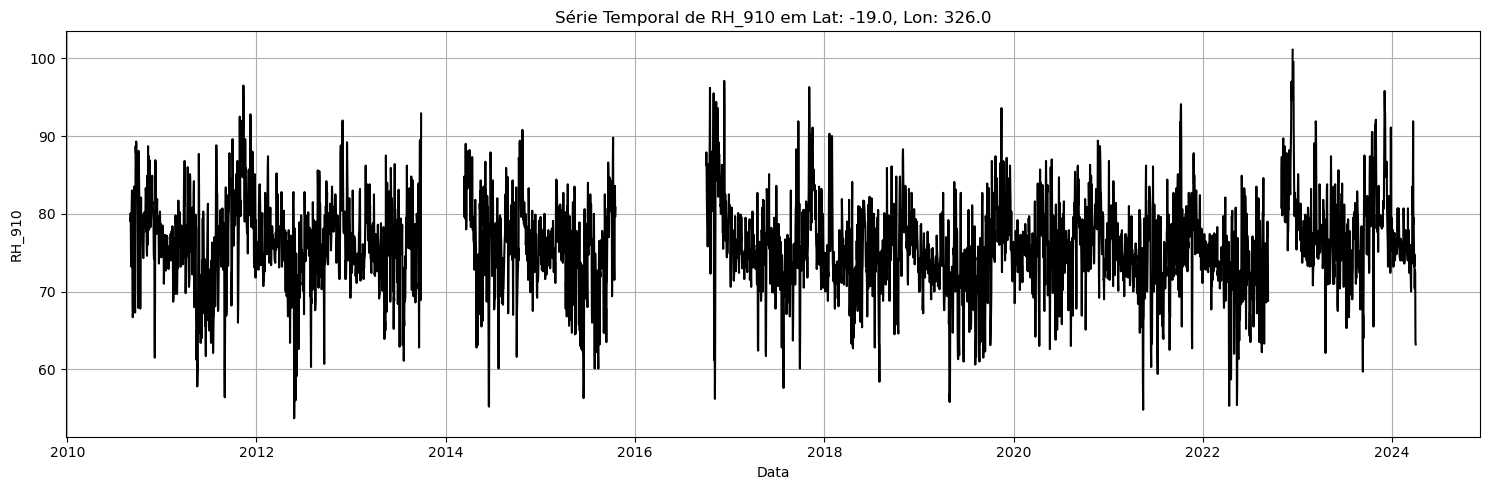

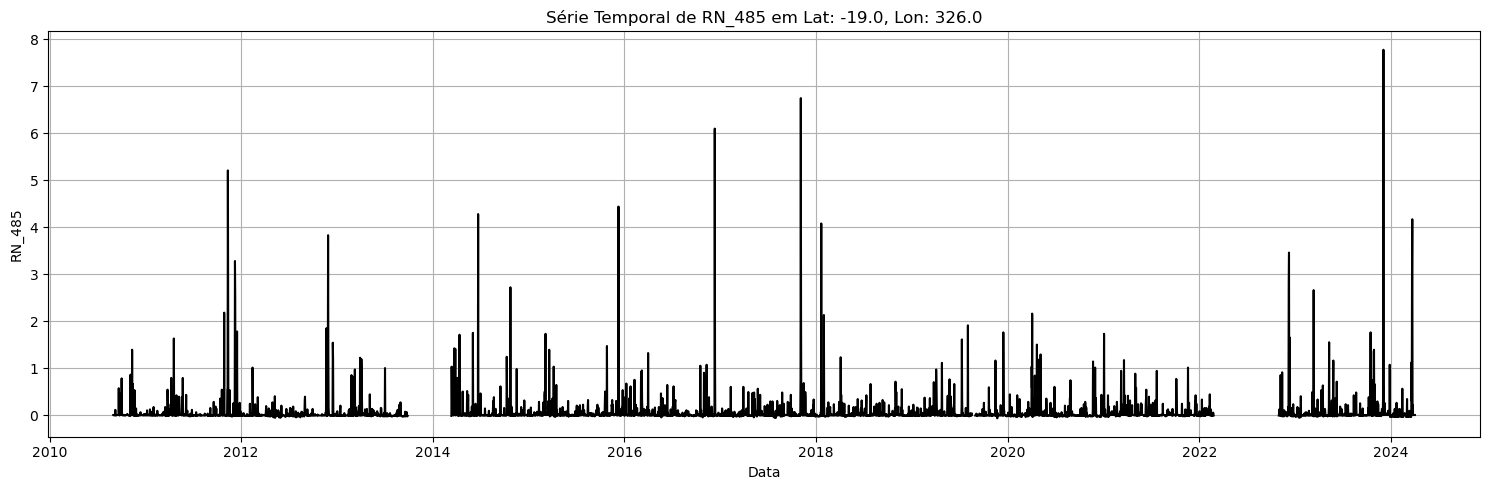

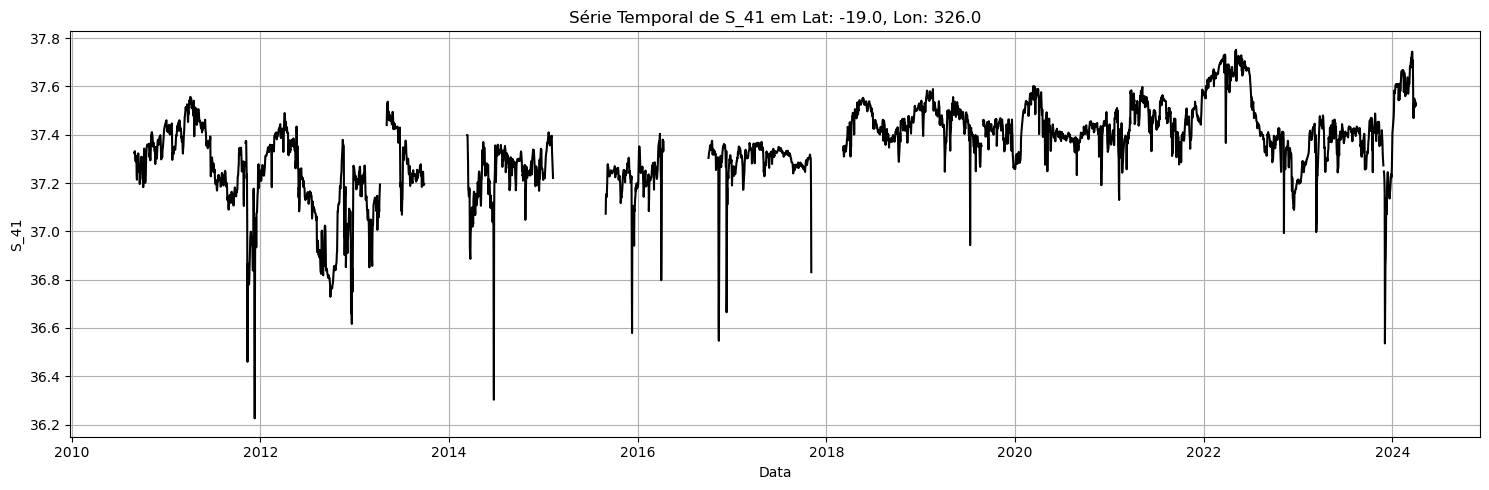

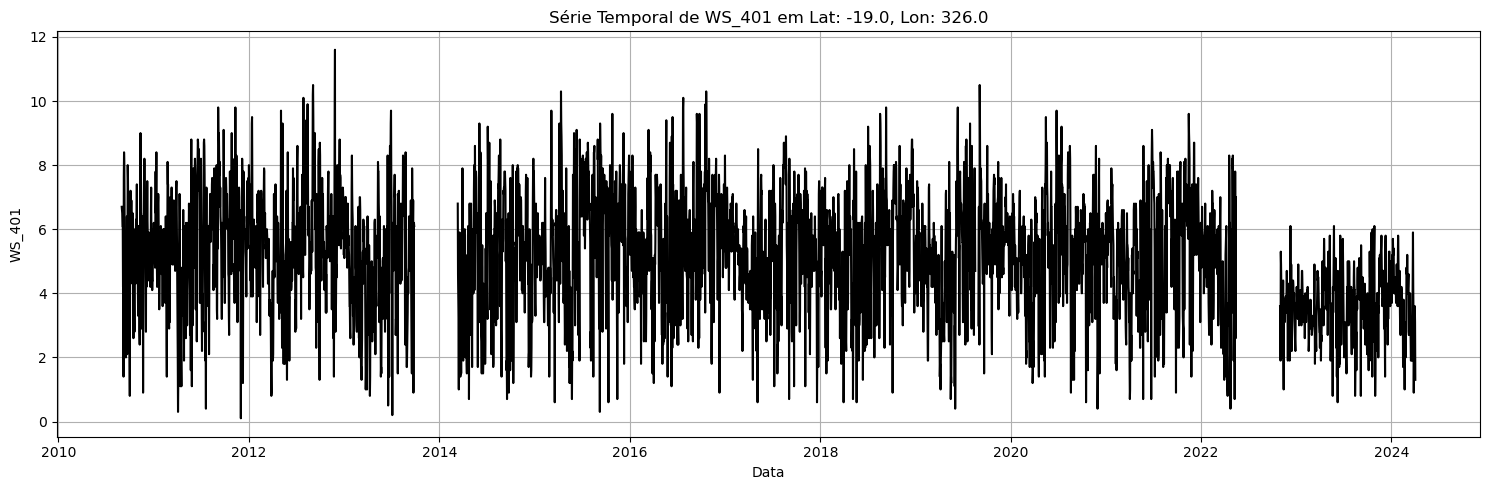

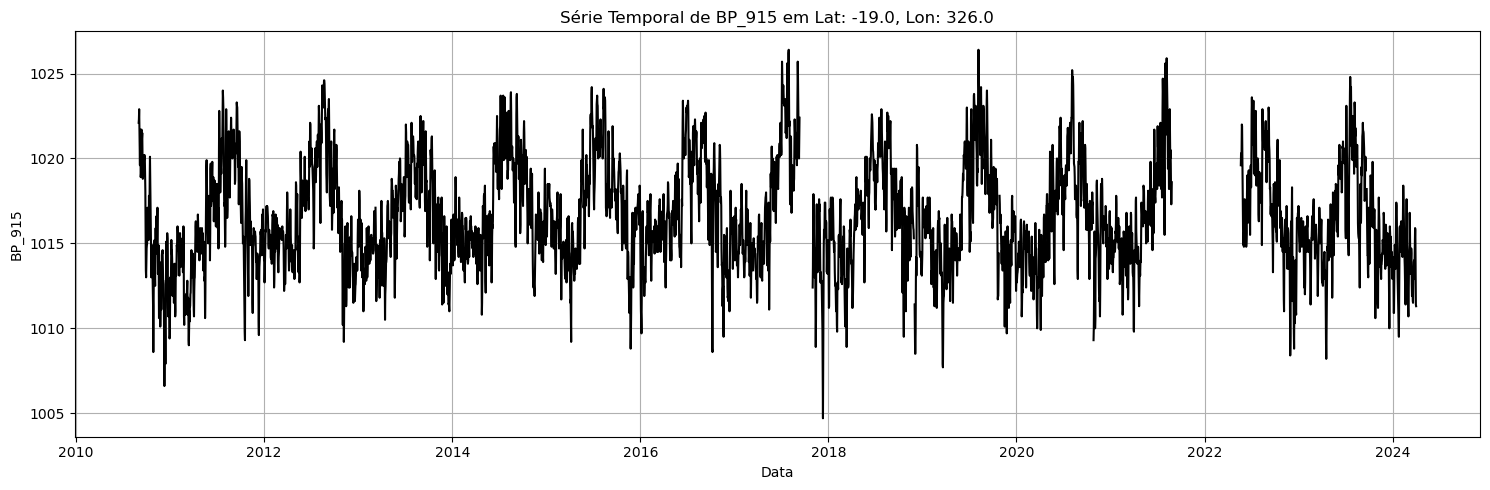

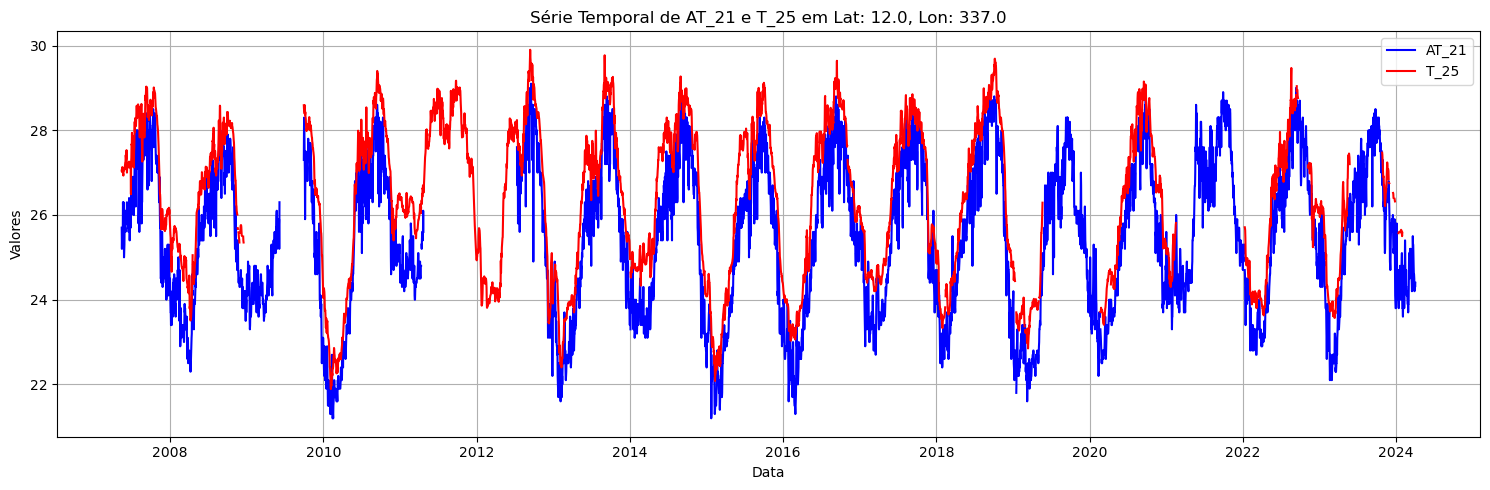

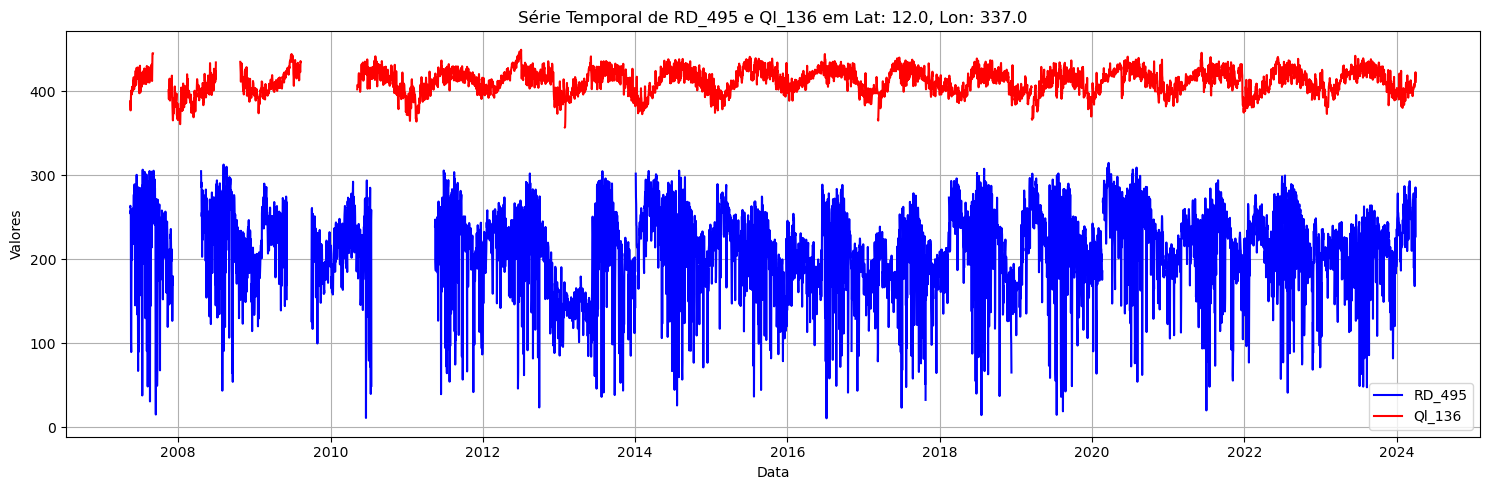

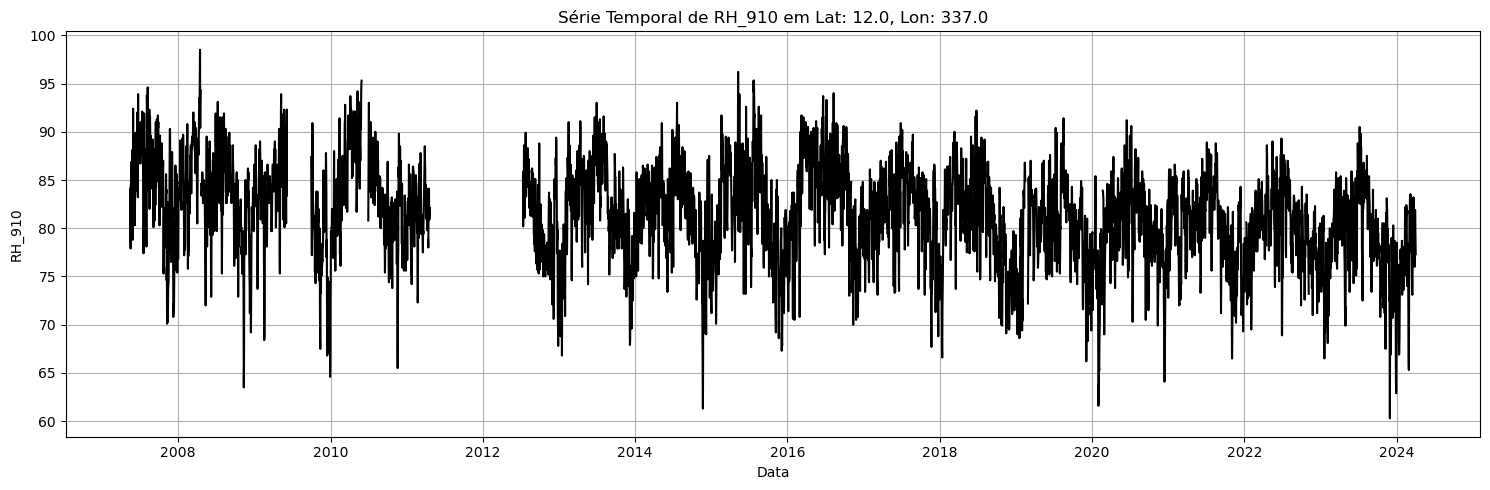

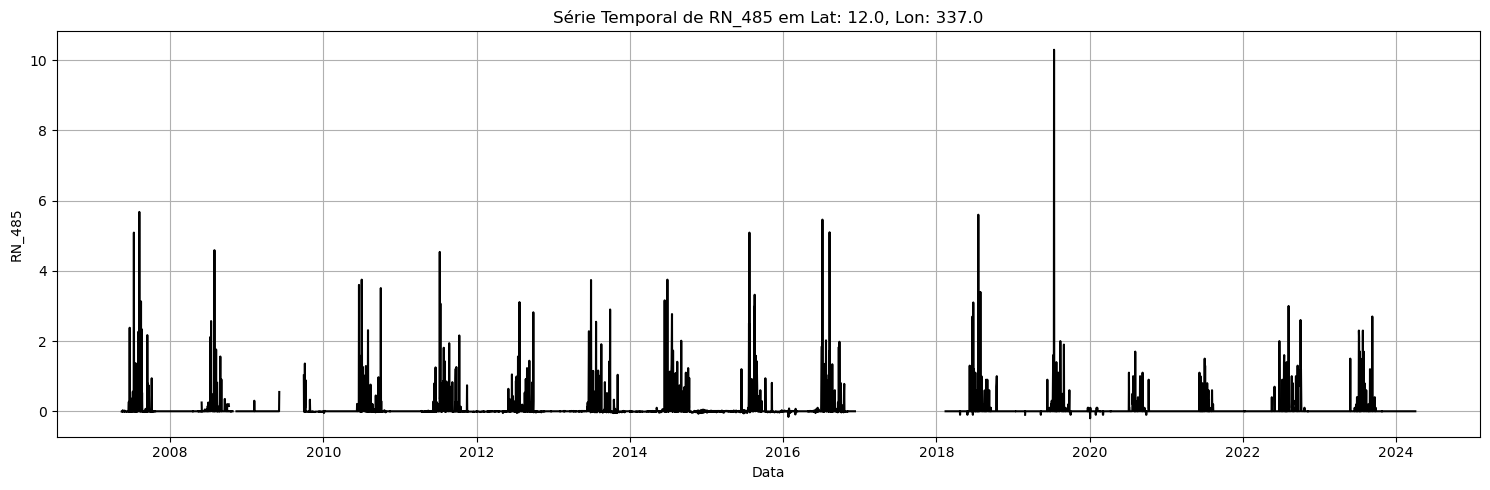

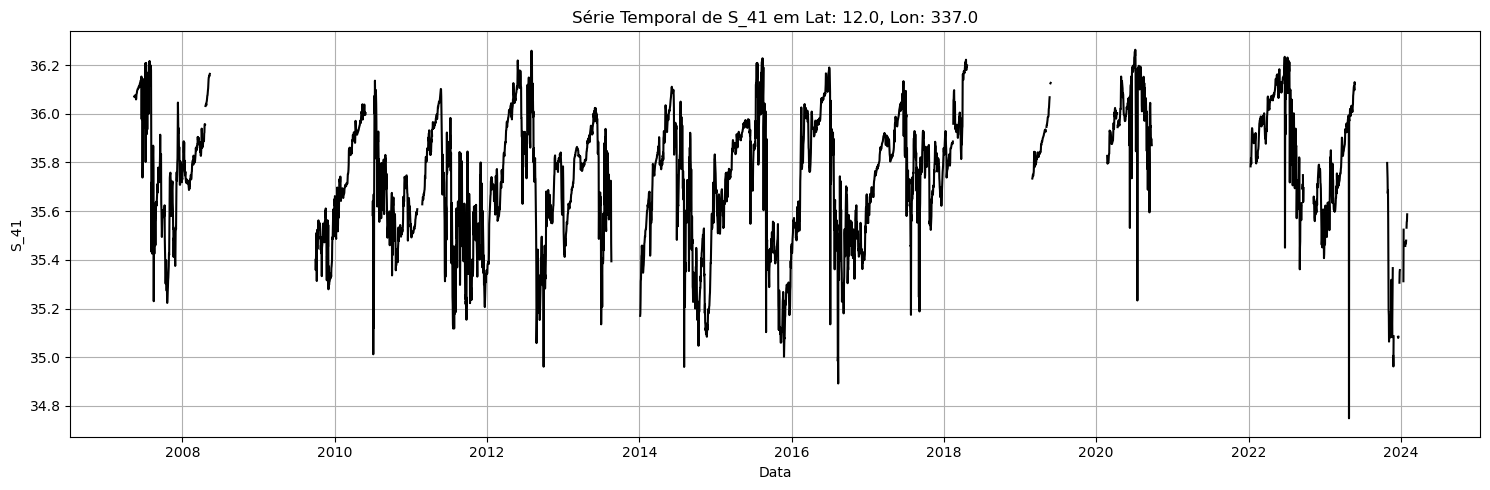

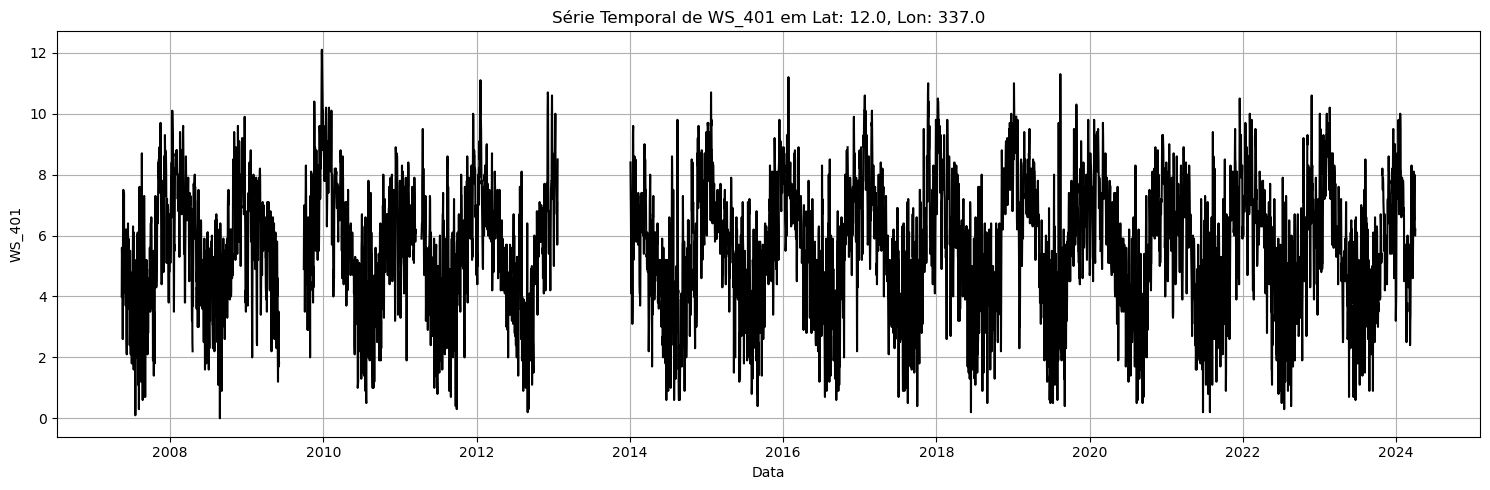

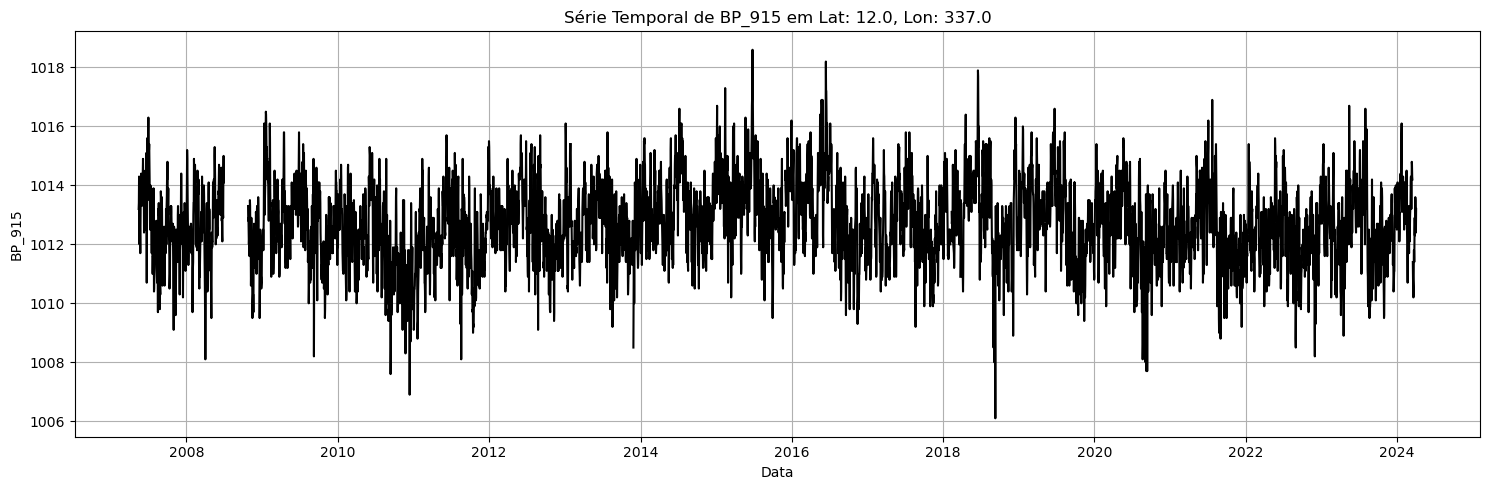

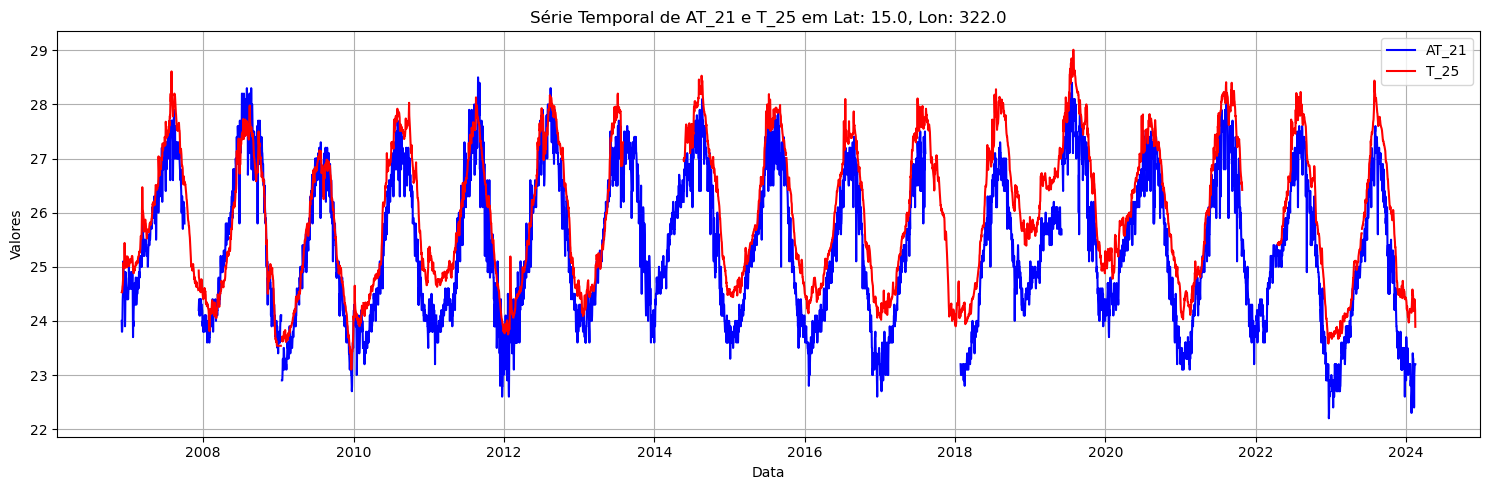

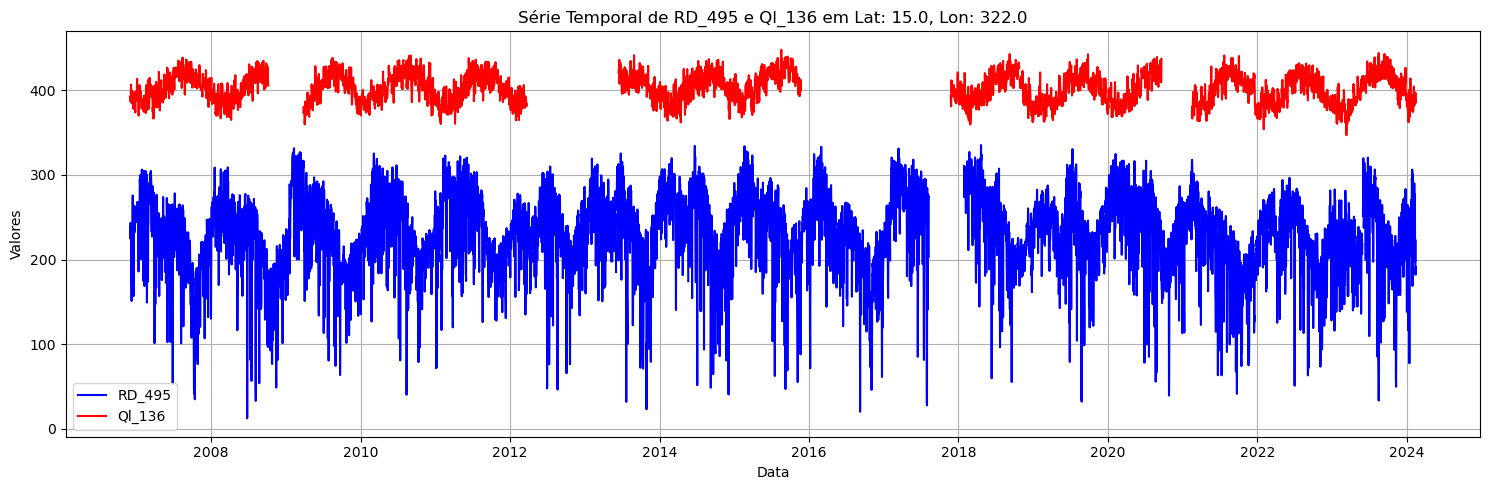

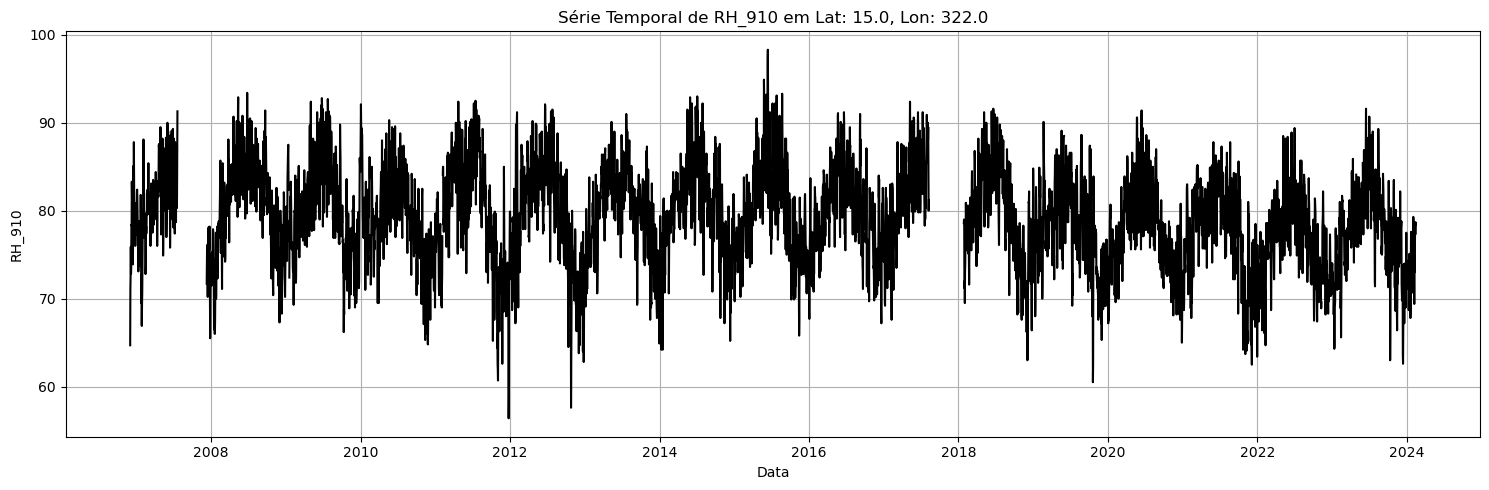

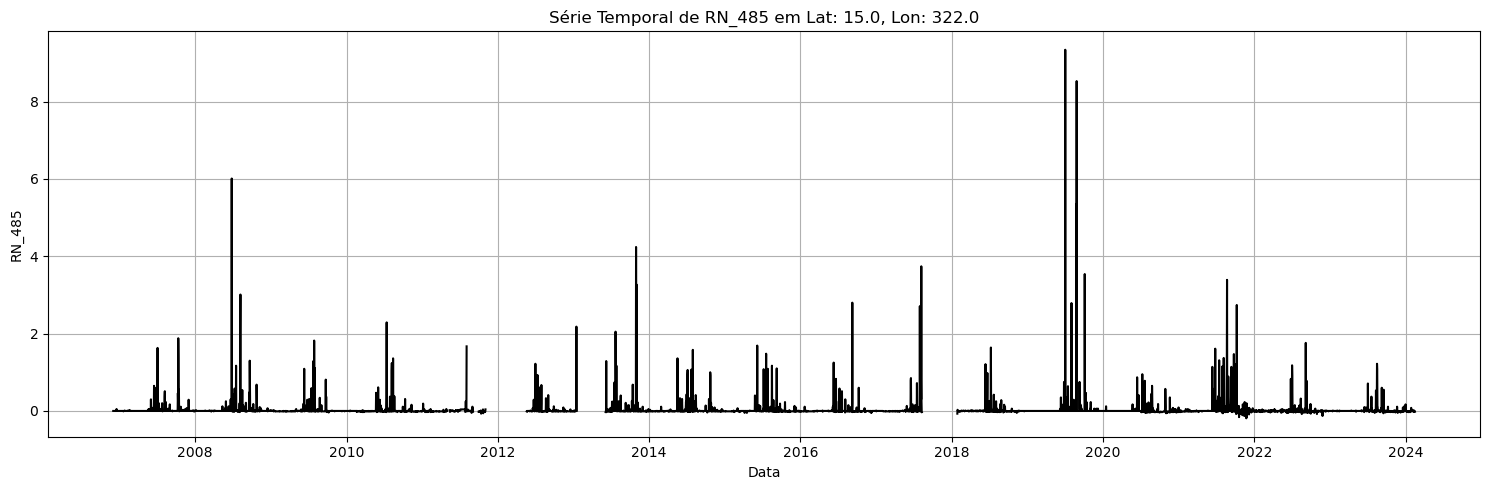

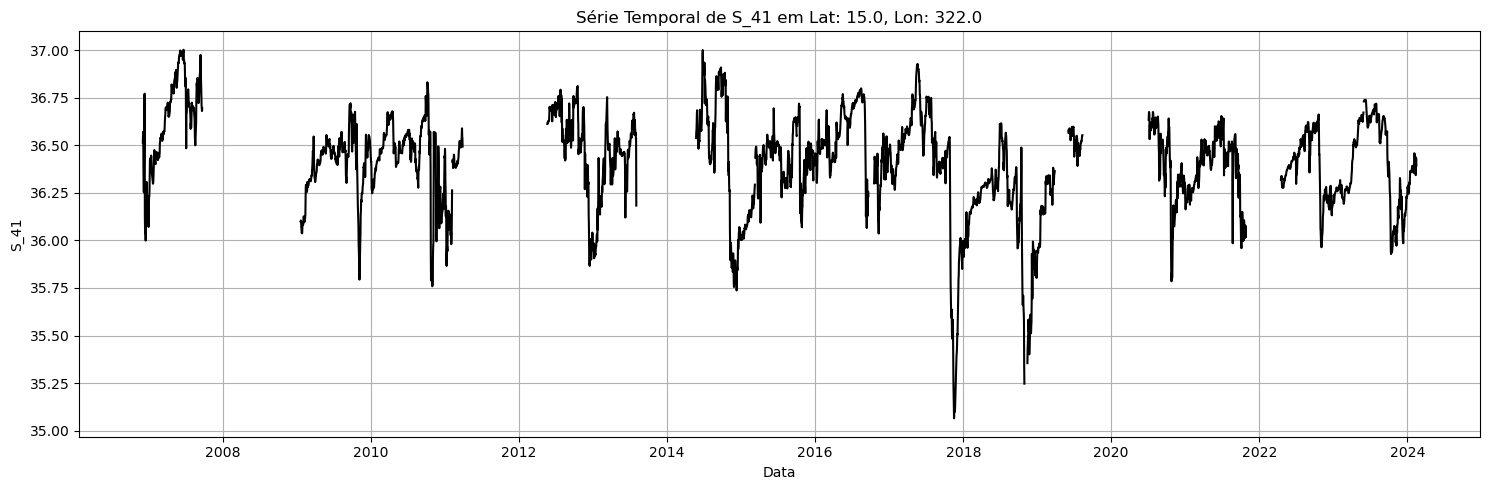

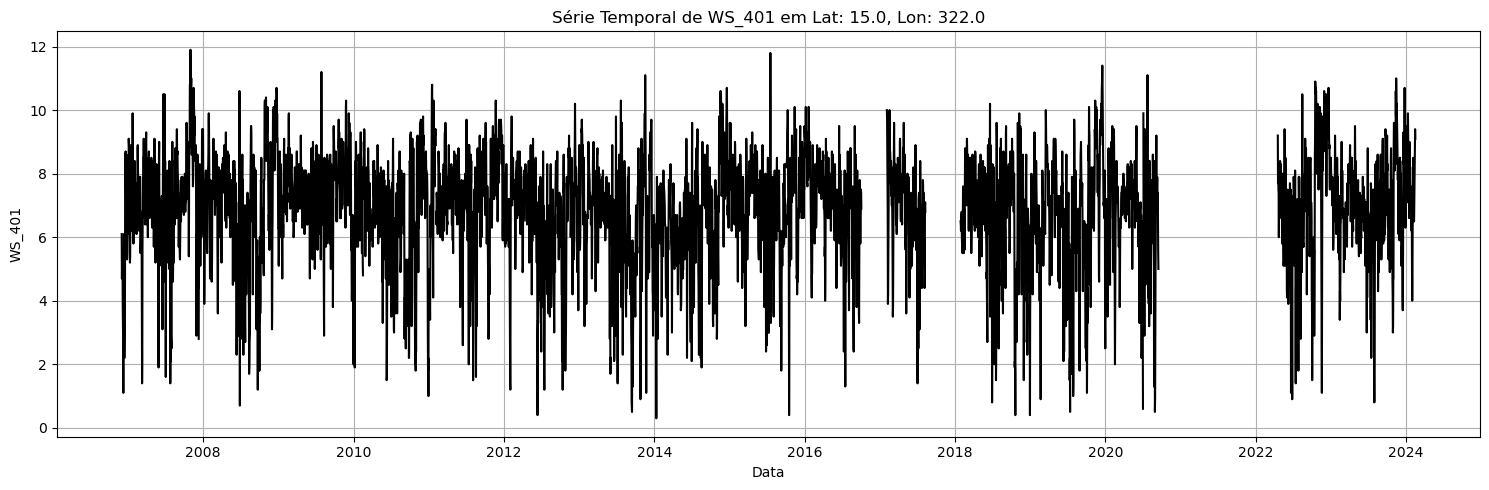

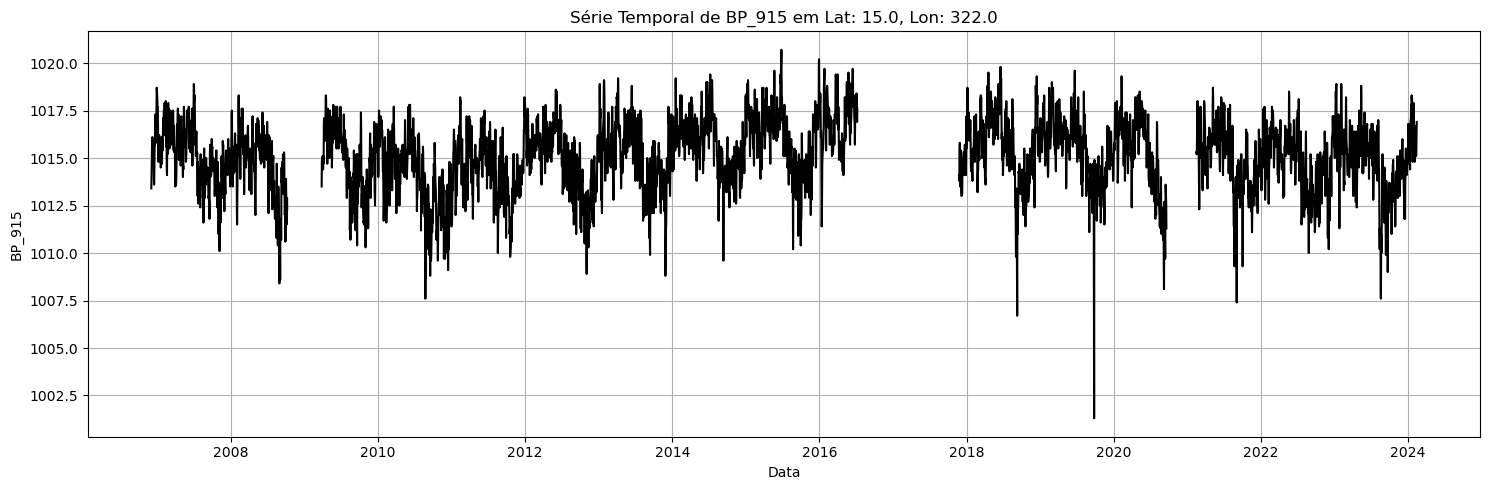

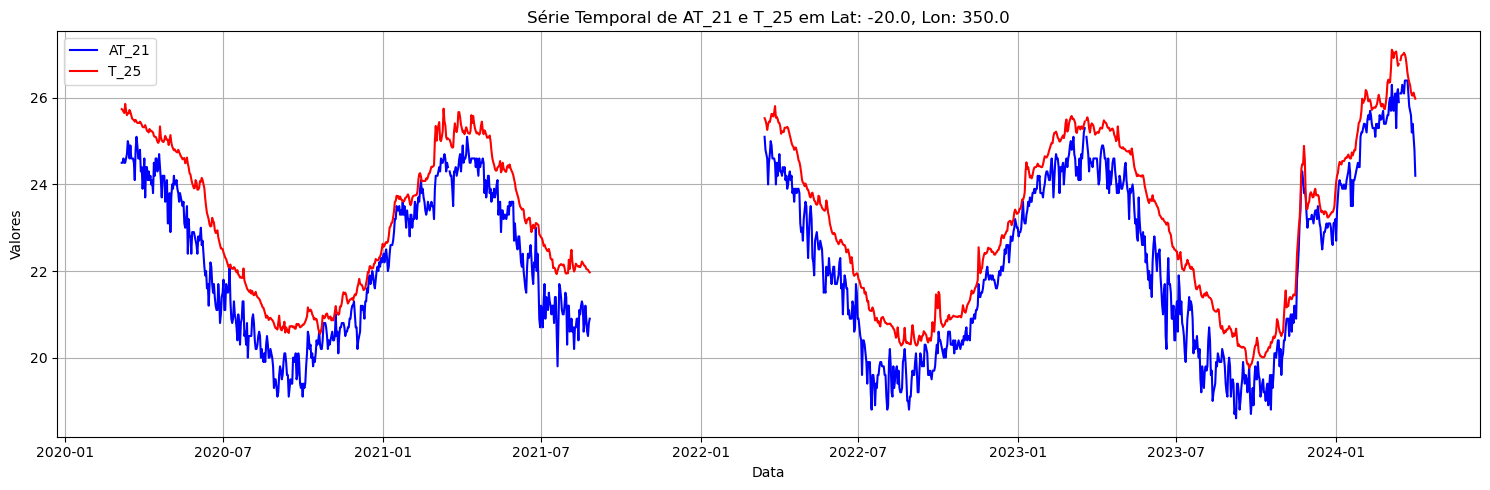

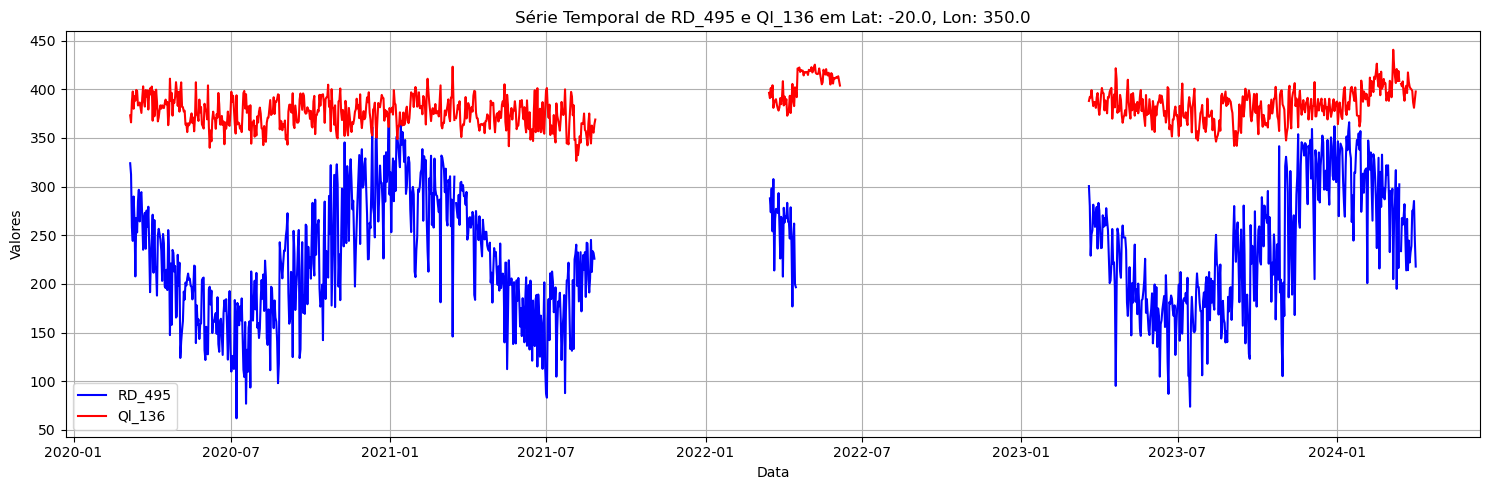

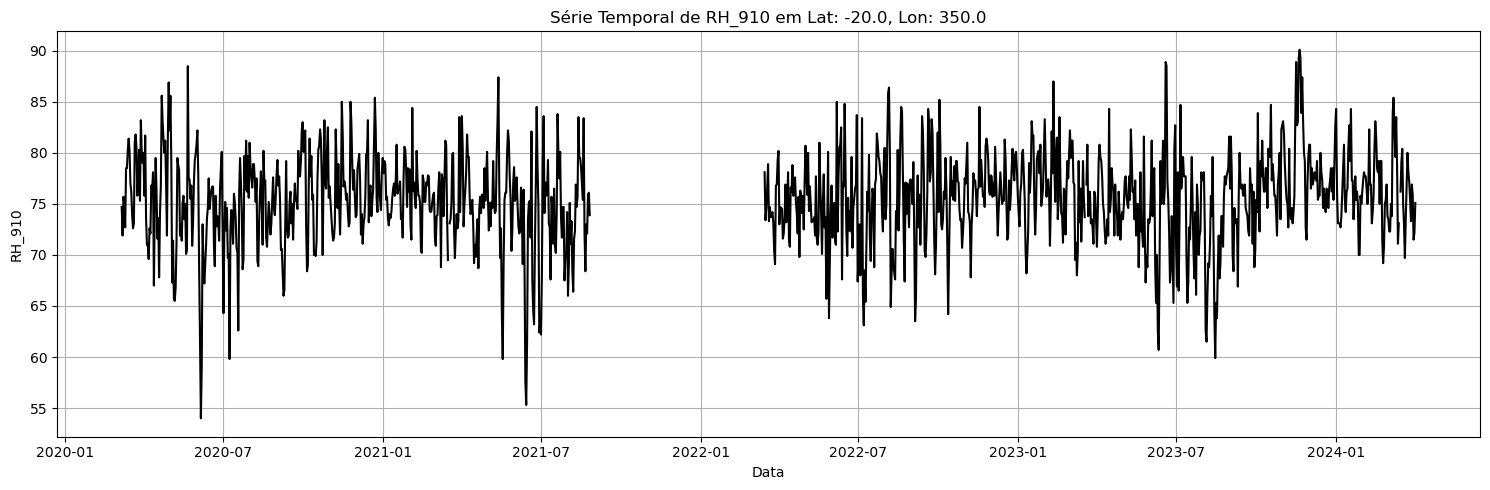

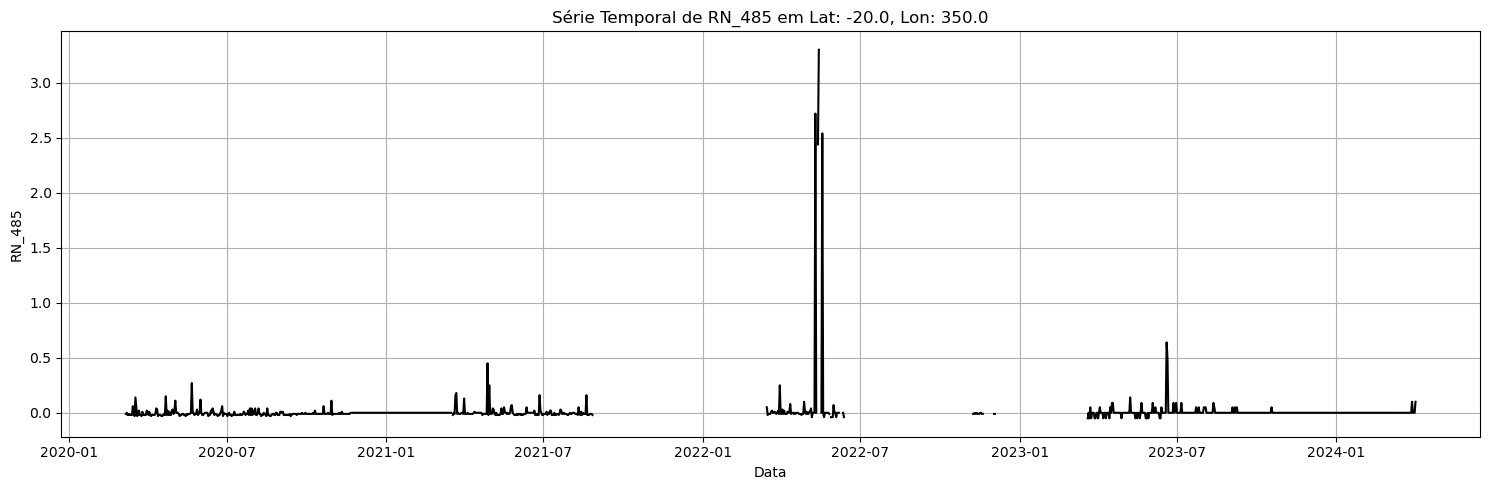

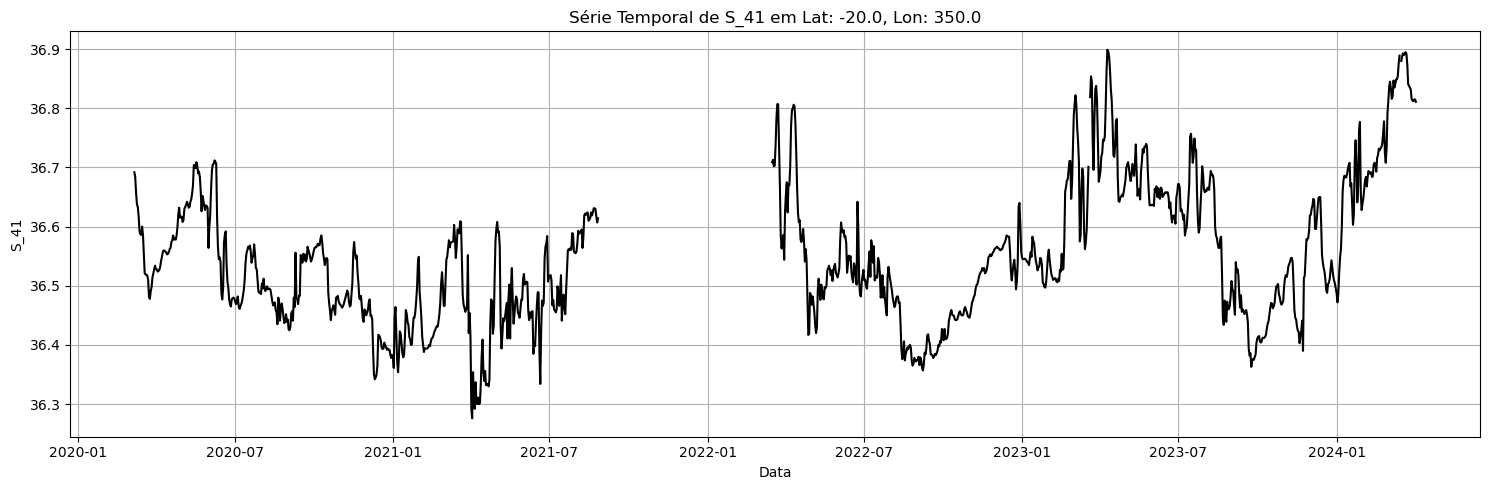

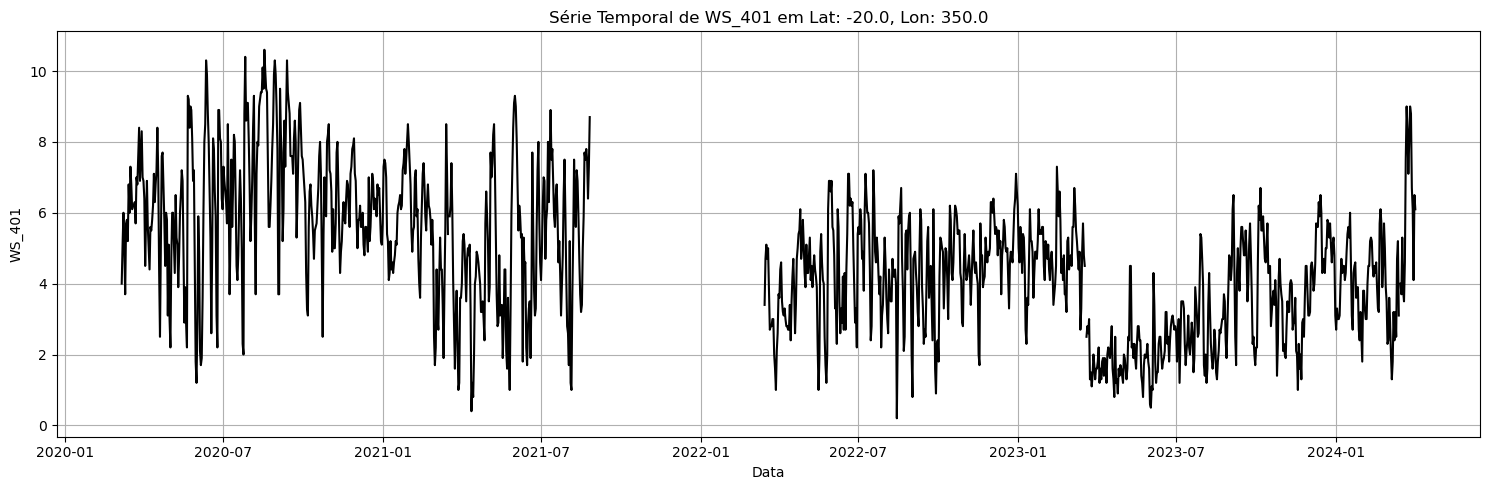

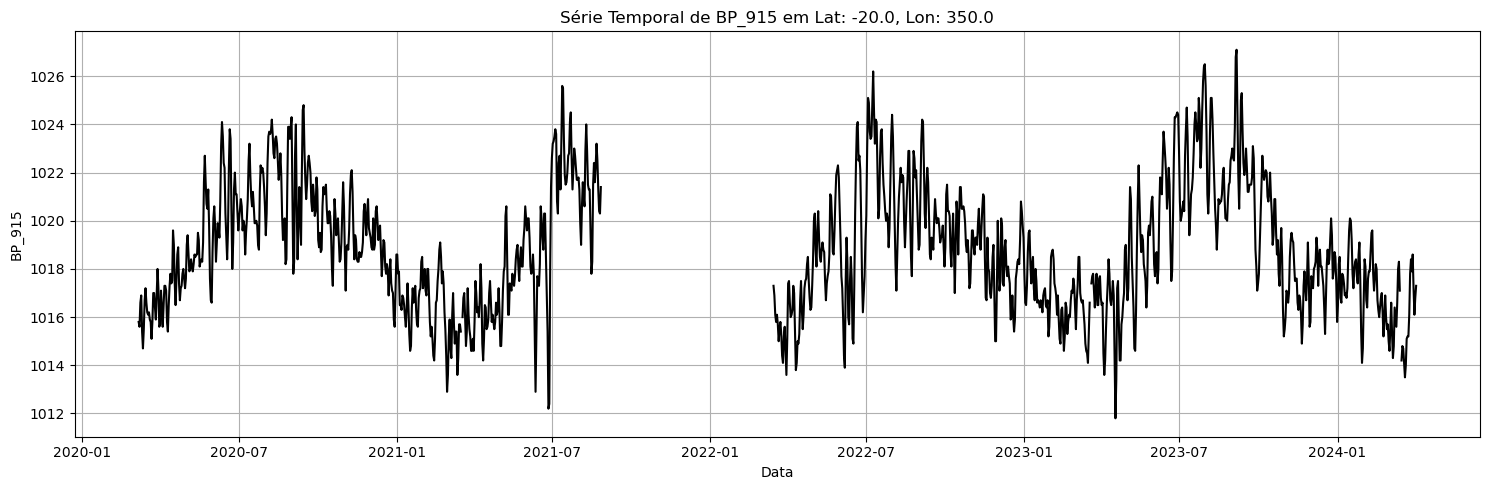

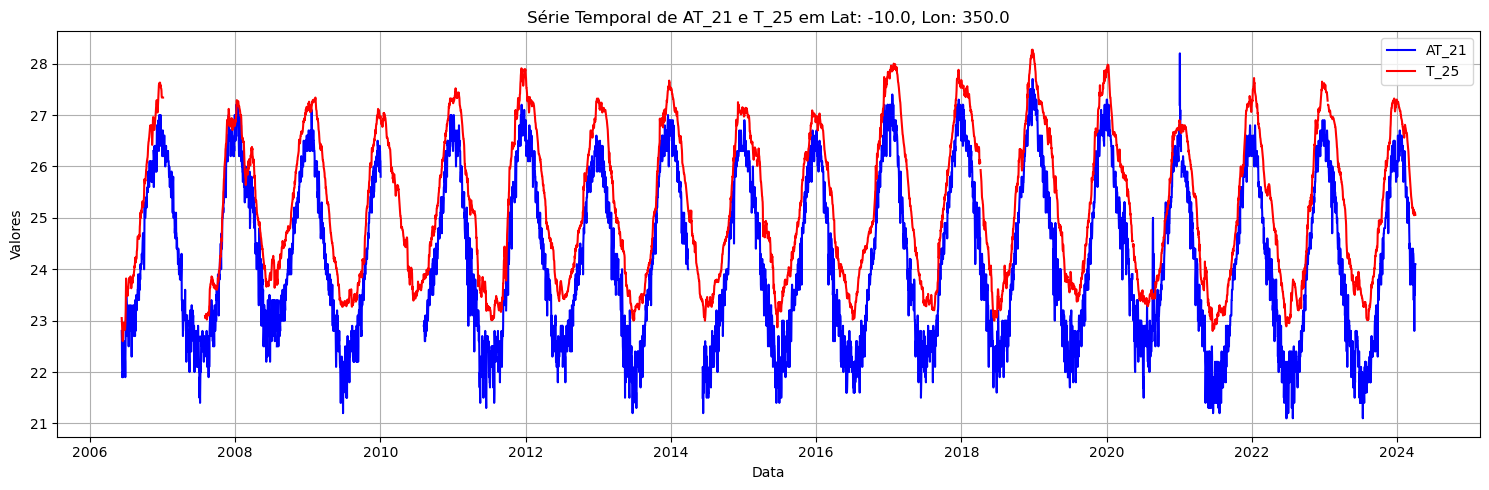

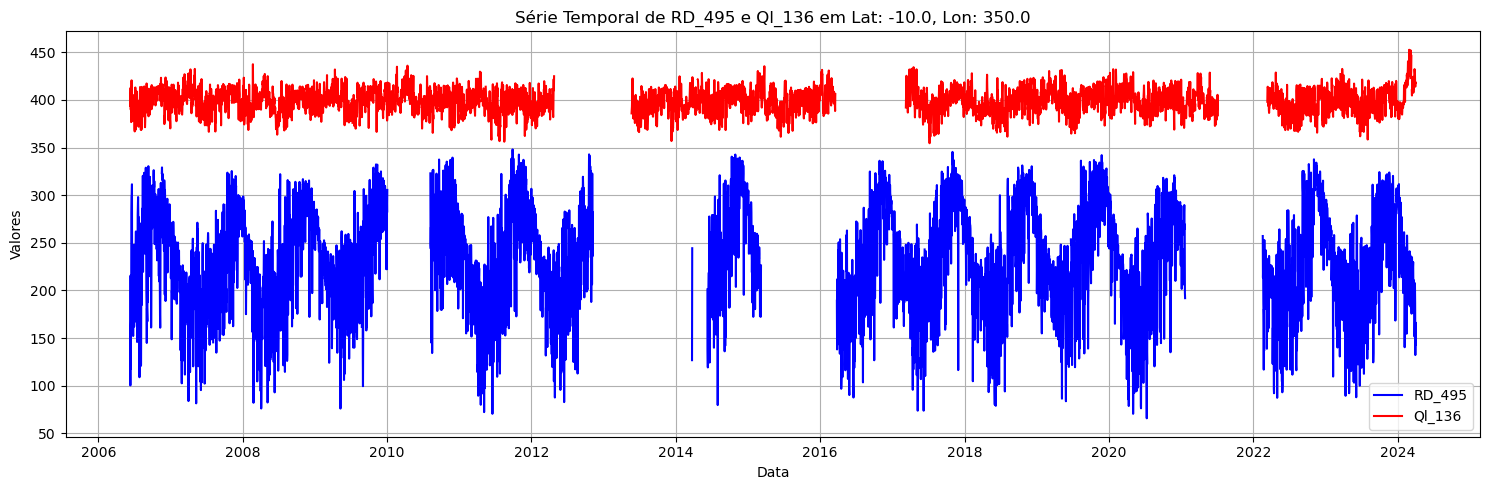

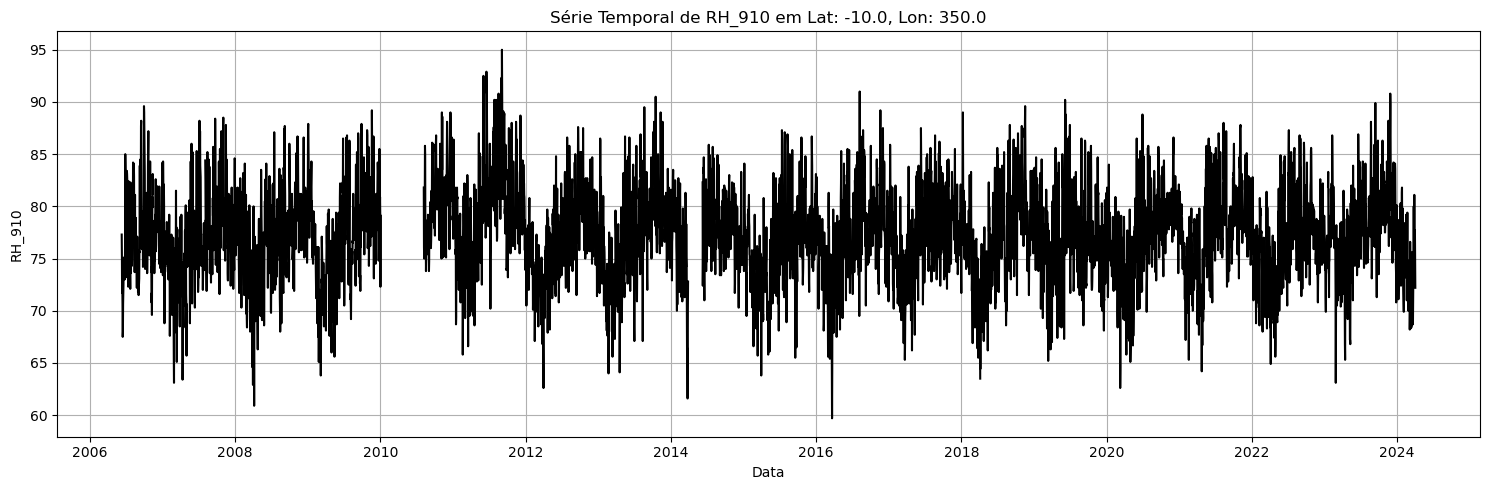

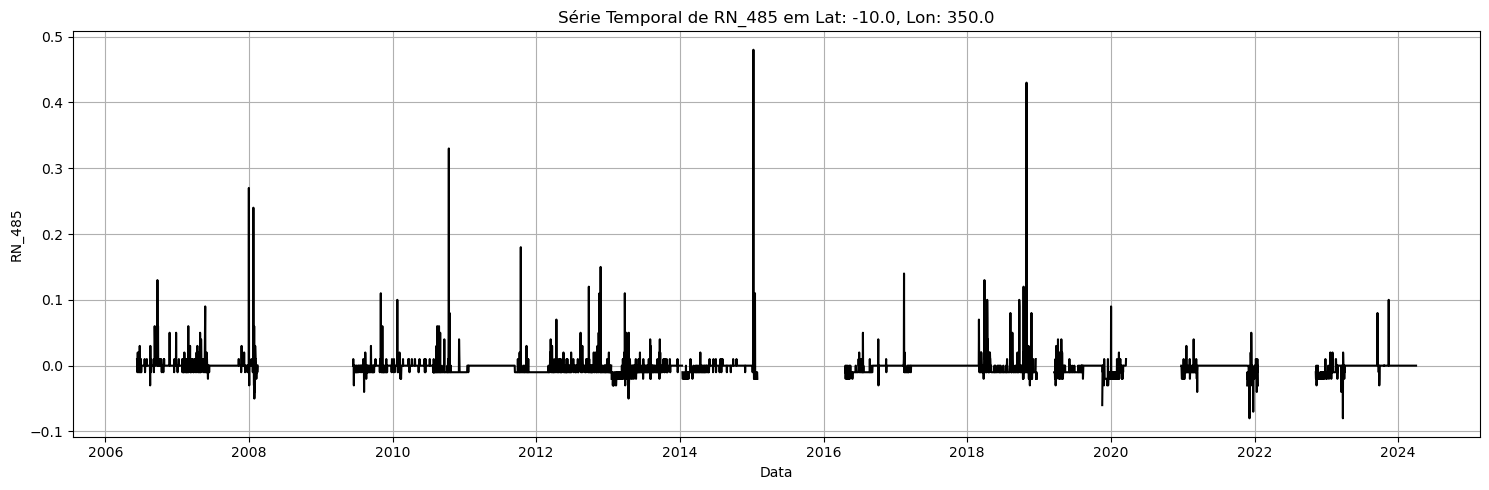

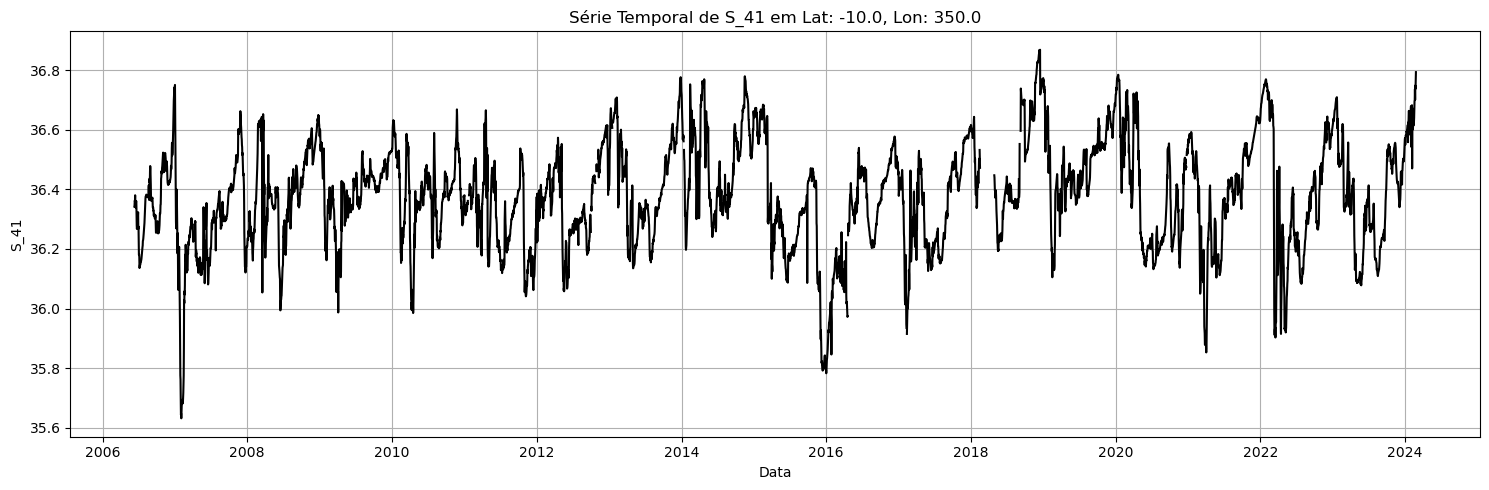

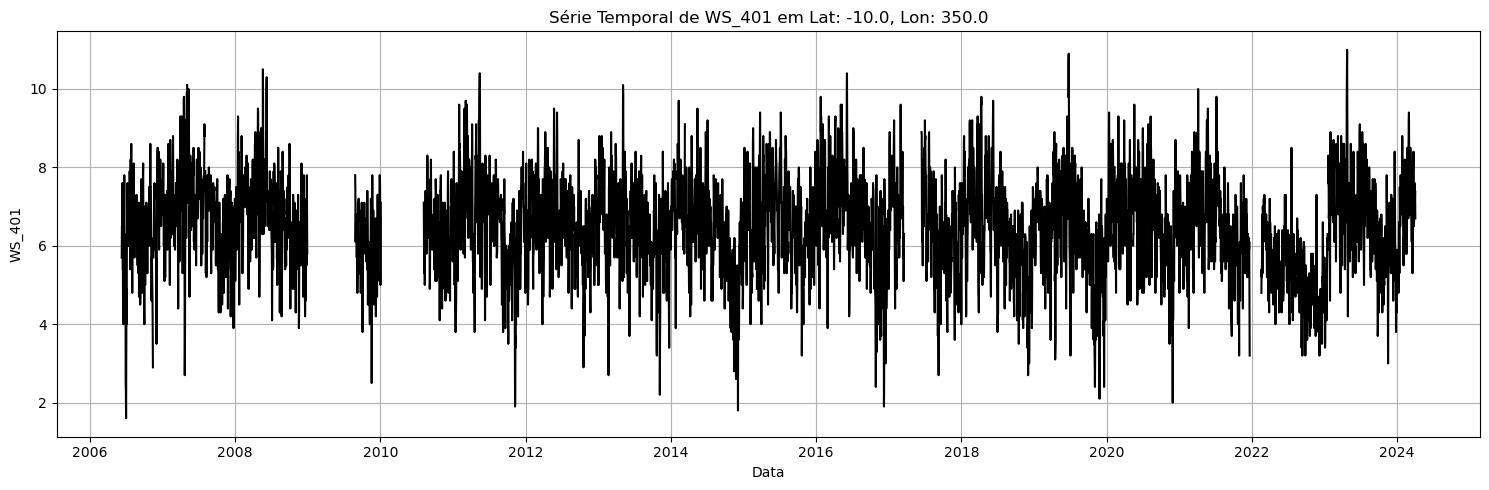

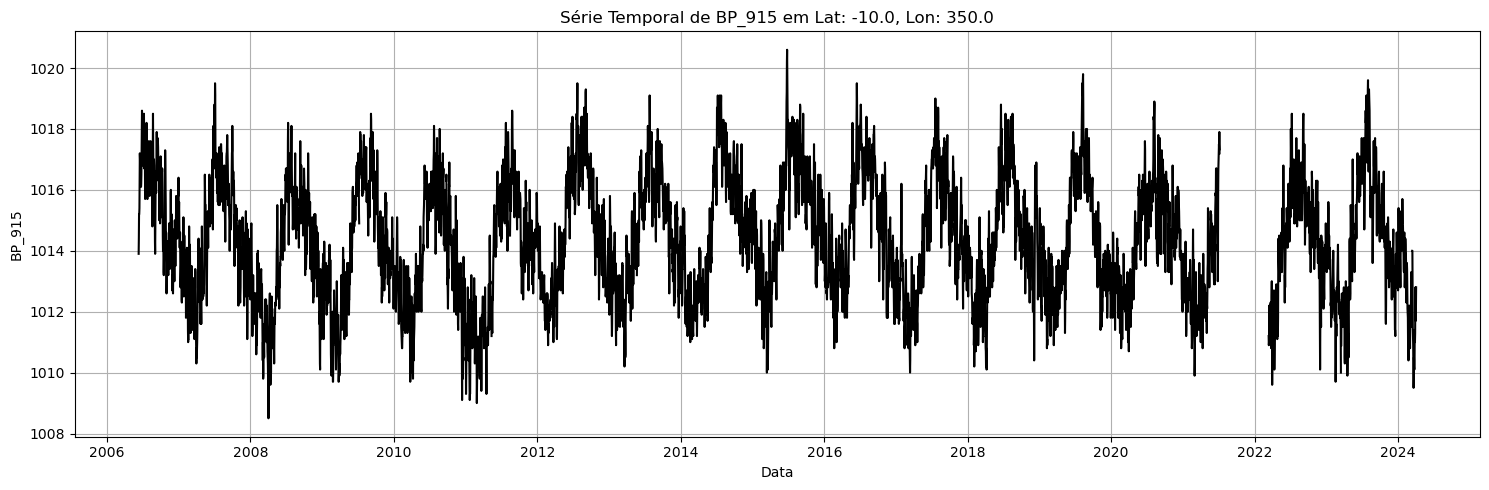

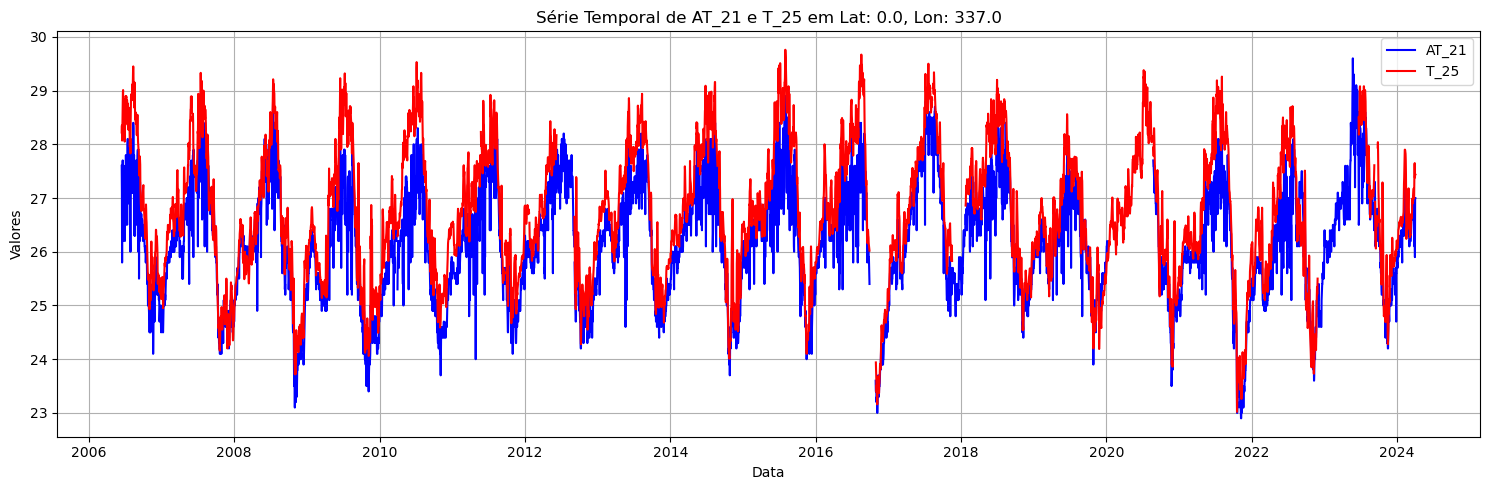

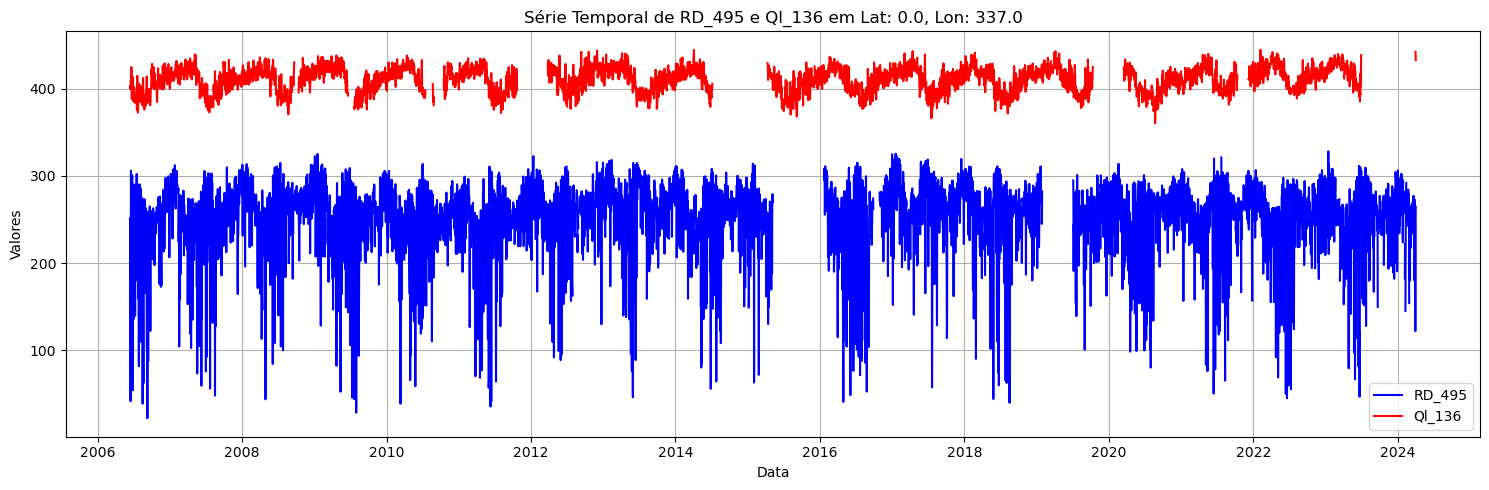

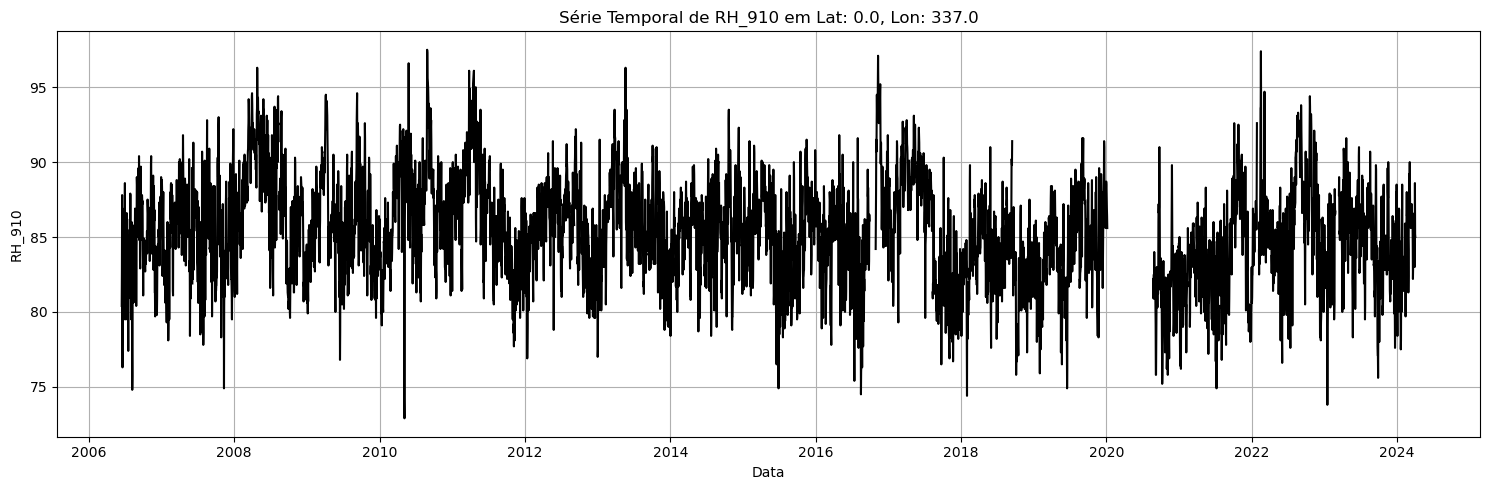

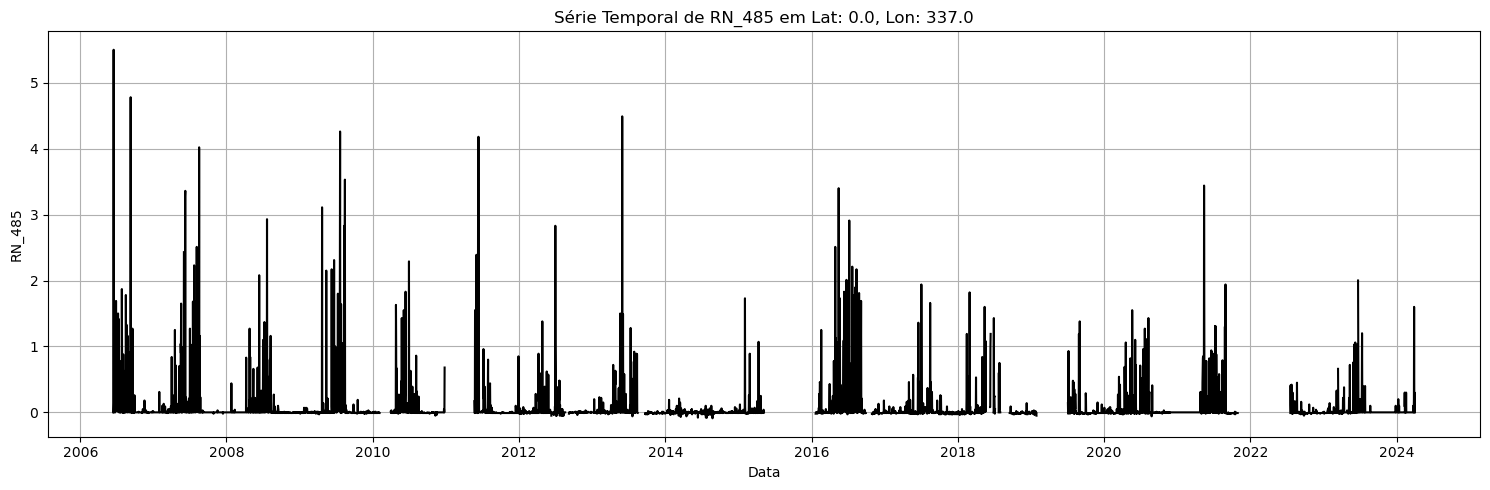

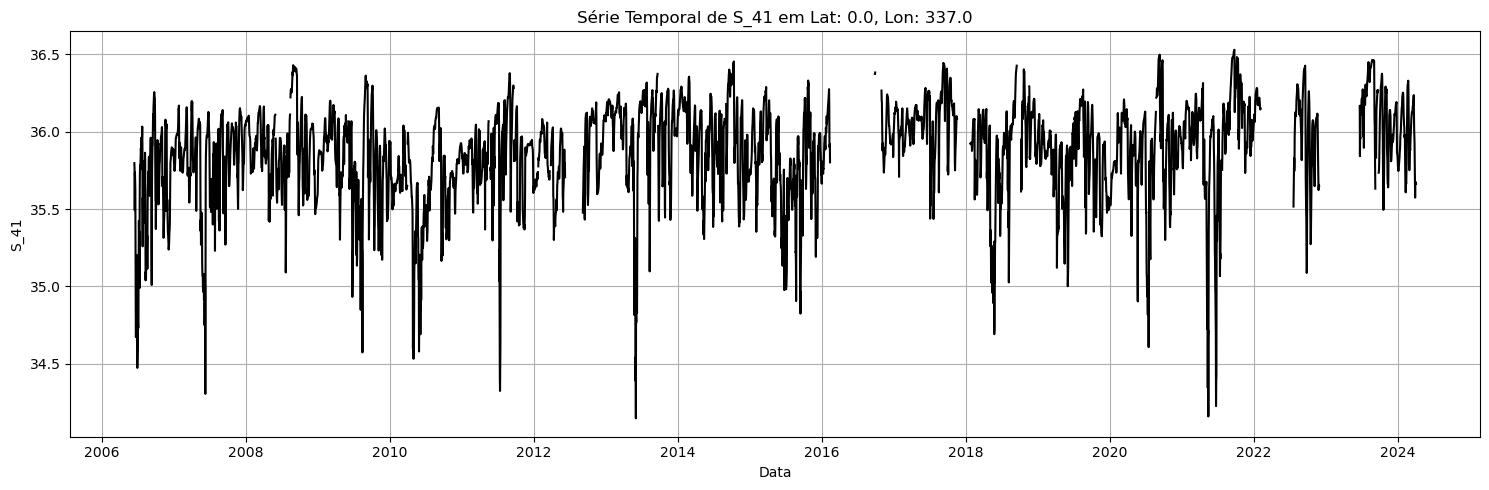

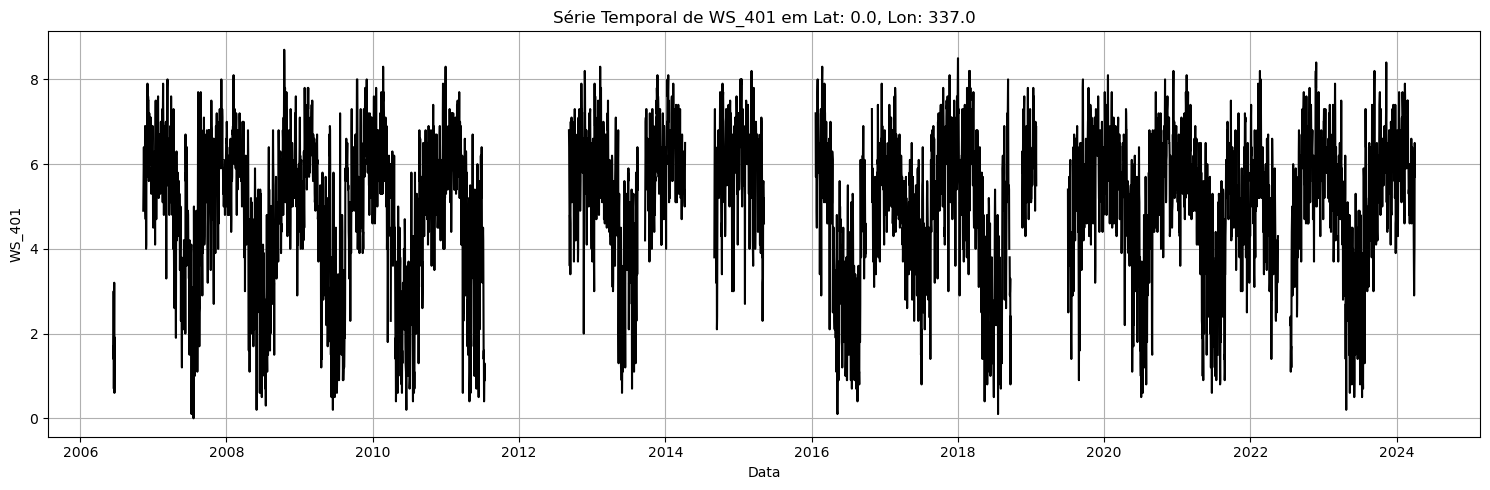

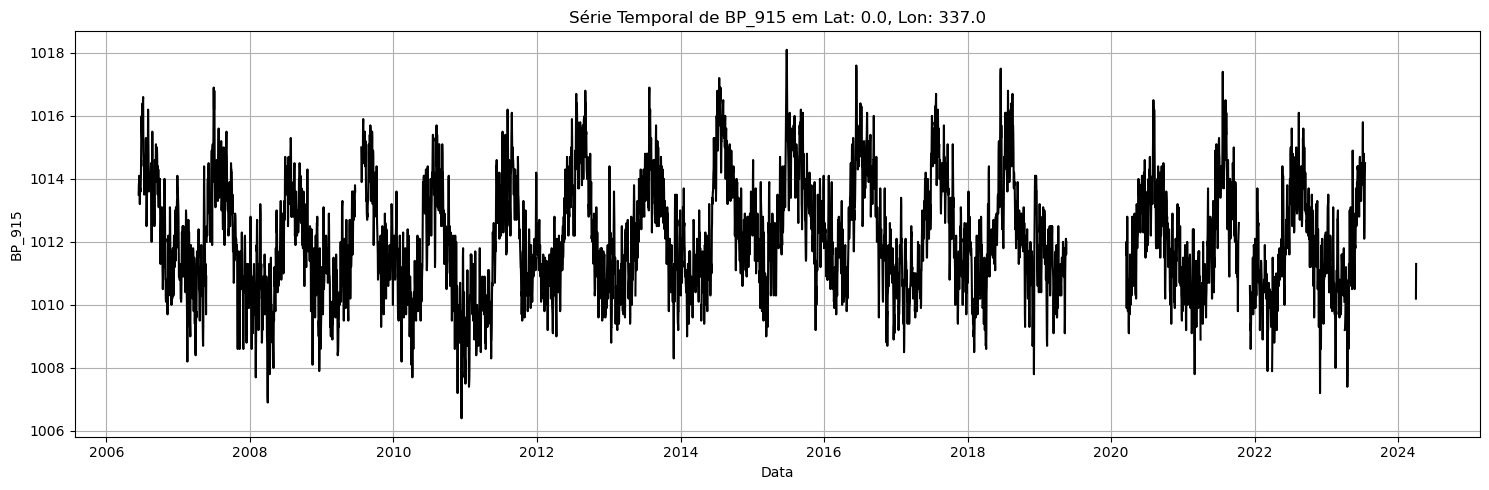

In [3]:
import numpy as np
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os  # Para manipular caminhos de diretórios e arquivo

# Defina o caminho da pasta onde estão seus arquivos NetCDF
caminho_pasta = "/home/leticia/Documentos/MESTRADO/Dados_diarios_boias/"  # Certifique-se de que o caminho está correto

# Definição das variáveis de interesse
variaveis_interesse = ["AT_21", "T_25", "RH_910", "RN_485", "RD_495","Ql_136", "S_41", "WS_401", "BP_915"]

# Caminho onde os gráficos serão salvos
diretorio_salvar = "/home/leticia/Documentos/MESTRADO/Dados_diarios_boias/figuras/"

def ler_dados(arquivo, variaveis_interesse):
    ds = nc.Dataset(arquivo)
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    tempo = ds.variables['time'][:]  # A variável 'time' geralmente está em dias desde uma data base

    datas = nc.num2date(tempo, units=ds.variables['time'].units)

    # Convert cftime.DatetimeGregorian objects to strings and then to pandas datetime objects
    datas = [str(date) for date in datas]  # Convert to string
    datas = pd.to_datetime(datas)  # Now convert the list of strings to pandas datetime objects

    fill_value = 1e35  # Valor usado para identificar dados ausentes

    dfs = {}
    for var in variaveis_interesse:
        if var in ds.variables:  # Checa se a variável está no arquivo
            dados = np.array(ds.variables[var][:])
            #if var not in ["T_25", "AT_21"]:
            dados = np.where(dados == fill_value, np.nan, dados)
            dados = dados.squeeze()  # Remove eixos de tamanho 1

            df = pd.DataFrame({
                'Data': datas,
                var: dados
            })

            df.set_index('Data', inplace=True)

            dfs[var] = df
            

    return lat.mean(), lon.mean(), dfs

def plotar_series_temporais(dfs, lat, lon, diretorio_salvar=None):
    # Verifica se as variáveis AT_21 e T_25 existem para plotá-las juntas
    if "AT_21" in dfs and "T_25" in dfs:
        plt.figure(figsize=(15,5))
        plt.plot(dfs["AT_21"].index.to_numpy(), dfs["AT_21"]["AT_21"].to_numpy(), label="AT_21", color='blue')
        plt.plot(dfs["T_25"].index.to_numpy(), dfs["T_25"]["T_25"].to_numpy(), label="T_25", color='red')
        plt.xlabel('Data')
        plt.ylabel('Valores')
        titulo = f"Série Temporal de AT_21 e T_25 em Lat: {lat:.1f}, Lon: {lon:.1f}"
        plt.title(titulo)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if diretorio_salvar:
            #plt.savefig(os.path.join(diretorio_salvar, f"AT_21_T_25_{lat:.1f}_{lon:.1f}.png"))
            plt.show()

    if "RD_495" in dfs and "Ql_136" in dfs:
        plt.figure(figsize=(15,5))
        plt.plot(dfs["RD_495"].index.to_numpy(), dfs["RD_495"]["RD_495"].to_numpy(), label="RD_495", color='blue')
        plt.plot(dfs["Ql_136"].index.to_numpy(), dfs["Ql_136"]["Ql_136"].to_numpy(), label="Ql_136", color='red')
        plt.xlabel('Data')
        plt.ylabel('Valores')
        titulo = f"Série Temporal de RD_495 e Ql_136 em Lat: {lat:.1f}, Lon: {lon:.1f}"
        plt.title(titulo)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if diretorio_salvar:
            #plt.savefig(os.path.join(diretorio_salvar, f"AT_21_T_25_{lat:.1f}_{lon:.1f}.png"))
            plt.show()
    # Plota as demais variáveis
    for var, df in dfs.items():
        if var not in ["AT_21", "T_25","RD_495","Ql_136"]:  # Ignora AT_21 e T_25 pois já foram plotadas
            plt.figure(figsize=(15,5))
            plt.plot(df.index.to_numpy(), df[var].to_numpy(), label=var, color='k')
            plt.xlabel('Data')
            plt.ylabel(var)
            titulo = f"Série Temporal de {var} em Lat: {lat:.1f}, Lon: {lon:.1f}"
            plt.title(titulo)
            plt.grid(True)
            plt.tight_layout()
            if diretorio_salvar:
                #plt.savefig(os.path.join(diretorio_salvar, f"{var}_{lat:.1f}_{lon:.1f}.png"))
                plt.show()


# Certifique-se de que o diretório existe
os.makedirs(diretorio_salvar, exist_ok=True)
# Alteração aqui: Use o glob para buscar todos os arquivos .cdf na pasta especificada
arquivos_netCDF = glob.glob(caminho_pasta + "*.cdf")

for arquivo in arquivos_netCDF:
    lat, lon, dfs = ler_dados(arquivo, variaveis_interesse)
    plotar_series_temporais(dfs, lat, lon, diretorio_salvar=diretorio_salvar)

# Criando CSV

In [17]:
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob
import os

def ler_dados_e_exportar_csv(arquivo, variaveis_interesse, pasta_saida):
    ds = nc.Dataset(arquivo)
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    tempo = ds.variables['time'][:]  # A variável 'time' geralmente está em dias desde uma data base.

    datas = nc.num2date(tempo, units=ds.variables['time'].units)

    fill_value = 1e35  # Valor usado para identificar dados ausentes.

    df_final = pd.DataFrame({
        'Data': datas
    })
    df_final.set_index('Data', inplace=True)

    for var in variaveis_interesse:
        if var in ds.variables:
            dados = ds.variables[var][:]
            #if var != "T_25" and var != "mag_vento":
            dados = np.where(dados == fill_value, np.nan, dados)
            dados = dados.squeeze()

            df_temp = pd.DataFrame({
                var: dados
            }, index=df_final.index)

            df_final = pd.concat([df_final, df_temp], axis=1)

    nome_arquivo_saida = os.path.splitext(os.path.basename(arquivo))[0] + ".csv"
    caminho_completo_saida = os.path.join(pasta_saida, nome_arquivo_saida)
    df_final.to_csv(caminho_completo_saida, float_format='%.2f')

    return lat.mean(), lon.mean(), nome_arquivo_saida

variaveis_interesse = ["AT_21", "T_25", "RH_910", "RN_485", "RD_495", "Ql_136", "S_41", "WS_401", "BP_915"]

caminho_pasta = "/home/leticia/Documentos/MESTRADO/Dados_diarios_boias"
arquivos_cdf = glob.glob(os.path.join(caminho_pasta, '*.cdf'))

for arquivo in arquivos_cdf:
    lat, lon, arquivo_saida = ler_dados_e_exportar_csv(arquivo, variaveis_interesse, caminho_pasta)
    print(f"Arquivo CSV criado: {arquivo_saida} em {caminho_pasta}")


Arquivo CSV criado: 20n38w.csv em /home/leticia/Documentos/MESTRADO/Dados_diarios_boias
Arquivo CSV criado: 19s34w.csv em /home/leticia/Documentos/MESTRADO/Dados_diarios_boias
Arquivo CSV criado: 12n23w.csv em /home/leticia/Documentos/MESTRADO/Dados_diarios_boias
Arquivo CSV criado: 15n38w.csv em /home/leticia/Documentos/MESTRADO/Dados_diarios_boias
Arquivo CSV criado: 20s10w.csv em /home/leticia/Documentos/MESTRADO/Dados_diarios_boias
Arquivo CSV criado: 10s10w.csv em /home/leticia/Documentos/MESTRADO/Dados_diarios_boias
Arquivo CSV criado: 0n23w.csv em /home/leticia/Documentos/MESTRADO/Dados_diarios_boias
